<a href="https://colab.research.google.com/github/vanessasinam/WildlifeTraffickingAnalysis/blob/main/Data_analysis_and_data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/sammitako/CS-GY-6513-Big-Data/blob/master/Data_analysis_and_data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pycountry

In [ ]:
# import libraries
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import requests
import time
import re
import unicodedata
import pycountry

# File Reader
We selected the columns that we need to answer the questions provided in the project list.
- Species: name, title, product, description, label_product
- Geography: domain, country, location, ships to, loc_name, lat, lon
- Price: price, currency

| Field         | Description                                           |
|---------------|-------------------------------------------------------|
| name          | Short version of the title                            |
| title         | Product Advertisement title                           |
| product       | Name of the product - can be same as title            |
| description   | Description of the product - can be same as title     |
| label_product | Zero shot classifier result label                     |
| domain        | Website where the product is posted                   |
| country       | Country where the advertisement was posted            |
| location      | Location of product                                   |
| ships_to      | Destination of product to be shipped                  |
| loc_name      | Detailed address of location                          |
| lat           | Latitude of the location address                      |
| lon           | Longitude of the location address                     |
| price         | Price of the product                                  |
| currency      | Currency of the price                                 |

In [ ]:
# combined_files.csv: merged .parquet format files
df = pd.read_csv('/content/drive/MyDrive/Big Data/Team Notebook/data/combined_files.csv')
print(df.columns)
print(df.columns.shape)

Index(['name', 'title', 'product', 'description', 'domain', 'country',
       'label_product', 'price', 'currency', 'production_data', 'image', 'url',
       'location', 'ships to', 'loc_name', 'lat', 'lon'],
      dtype='object')
(17,)


In [ ]:
df.head()

,name,title,product,description,domain,country,label_product,price,currency,production_data,image,url,location,ships to,loc_name,lat,lon
0,20MM RED LEATHER Watch Strap Real Flat Ostrich...,20MM RED LEATHER Watch Strap Real Flat Ostrich...,20MM RED LEATHER Watch Strap Real Flat Ostrich...,20mm Red Leather Watch Strap Real Flat Ostrich...,picclick.com,NaN,an animal body part,21.99,USD,None,https://www.picclickimg.com/4asAAOSwAatkmpPo/2...,http://picclick.com/20mm-Red-Leather-Watch-Str...,"Houston, Texas, US",None,NaN,NaN,NaN
1,"20PKS 3"" FISHING Rock Cod Rig Twin Bulb Squids...","20PKS 3"" FISHING Rock Cod Rig Twin Bulb Squids...","20PKS 3"" FISHING Rock Cod Rig Twin Bulb Squids...","20pks 3"" Fishing Rock Cod Rig Twin Bulb Squids...",picclick.com,NaN,an object,46.88,USD,None,https://www.picclickimg.com/ZW4AAOSwBKNjTkVr/2...,http://picclick.com/20pks-3-Fishing-Rock-Cod-R...,"Chino Hills, California, US",None,NaN,NaN,NaN
2,25 UNPAINTED SALTWATER Round Ball Jig Heads Re...,25 UNPAINTED SALTWATER Round Ball Jig Heads Re...,25 UNPAINTED SALTWATER Round Ball Jig Heads Re...,25 Unpainted Saltwater Round Ball Jig Heads Re...,picclick.com,NaN,an object,30.20,USD,None,https://www.picclickimg.com/NH0AAOSwNmVkutkl/2...,http://picclick.com/25-Unpainted-Saltwater-Rou...,"Sayre, Pennsylvania, US",None,NaN,NaN,NaN
3,2893 KUHNERT 1911 - African Ostrich,2893 KUHNERT 1911 - African Ostrich $7.34 - Pi...,2893 KUHNERT 1911 - African Ostrich $7.34 - Pi...,2893 Kuhnert 1911 - African Ostrich. Giclee Fi...,picclick.com,NaN,an animal body part,7.34,USD,None,https://www.picclickimg.com/ABAAAOSwYrtjm-Ii/2...,http://picclick.com/2893-Kuhnert-1911-African-...,"Kirchen - Herkersdorf, DE",None,NaN,NaN,NaN
4,40/20PCS SOFT FISHING Lure Paddle Tail Swimbai...,40/20PCS SOFT FISHING Lure Paddle Tail Swimbai...,40/20PCS SOFT FISHING Lure Paddle Tail Swimbai...,40/20Pcs Soft Fishing Lure Paddle Tail Swimbai...,picclick.com,NaN,an object,7.99,USD,None,https://www.picclickimg.com/qFgAAOSwsxdkrjzO/4...,http://picclick.com/40-20Pcs-Soft-Fishing-Lure...,"Guangzhou, CN",None,NaN,NaN,NaN


In [ ]:
df.shape[0]

375726

# Value constraints and uniqueness

## Examining the 'label_product' Column

The 'label_product' column contains seven categories, and we cannot guarantee that these categories are free from potential trafficking. However, we will operate under the assumption that these labels have been accurately classified through Zero-shot Classification by [VIDA-NYU](https://github.com/VIDA-NYU/wildlife_pipeline). Therefore, we will retain only those records where 'label_product' is categorized as 'an animal body part' or 'a real animal'.

In [ ]:
unique_label_products = df['label_product'].unique()
print(unique_label_products)

['an animal body part' 'an object' 'a print of an animal' 'a toy'
 'a faux animal body part' 'a faux animal' 'a real animal']


In [ ]:
# Drop rows where 'label_product' is neither 'an animal body part' nor 'a real animal'
df = df[~((df['label_product'] != 'an animal body part') & (df['label_product'] != 'a real animal'))]
df.shape[0]

95543

In [ ]:
df['label_product'].unique()

array(['an animal body part', 'a real animal'], dtype=object)

## Data containing NULL values
- Originally, the dataset contained 375,726 rows. However, after excluding specific 'label_product' categories, the total number of rows has been reduced to 95,543.
- The columns 'description', 'country', 'image', 'location', 'loc_name', 'lat', 'lon', and 'price' contain NULL values.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95543 entries, 0 to 375658
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             95543 non-null  object 
 1   title            95543 non-null  object 
 2   product          95543 non-null  object 
 3   description      95513 non-null  object 
 4   domain           95543 non-null  object 
 5   country          66 non-null     object 
 6   label_product    95543 non-null  object 
 7   price            64666 non-null  float64
 8   currency         95543 non-null  object 
 9   production_data  95543 non-null  object 
 10  image            95539 non-null  object 
 11  url              95543 non-null  object 
 12  location         5725 non-null   object 
 13  ships to         95543 non-null  object 
 14  loc_name         66 non-null     object 
 15  lat              66 non-null     float64
 16  lon              66 non-null     float64
dtypes: float64(

### Change the string "None" to actual "NaN" values in a DataFrame
We discovered that the columns 'title', 'product', 'description', and 'currency' represent NULL values as 'None' in the dataframe, resulting in an incorrect count of the number of rows. Therefore, we need to examine these columns as well.

In [ ]:
df = df.replace('None', np.nan)

In [ ]:
# Rename the 'production_data' column to 'production_date' for late use
df.rename(columns={'production_data': 'production_date'}, inplace=True)

# Now, the 'name' and 'ship to' fields display NULL values.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95543 entries, 0 to 375658
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             68666 non-null  object 
 1   title            95543 non-null  object 
 2   product          95543 non-null  object 
 3   description      68296 non-null  object 
 4   domain           95543 non-null  object 
 5   country          66 non-null     object 
 6   label_product    95543 non-null  object 
 7   price            64666 non-null  float64
 8   currency         64068 non-null  object 
 9   production_date  338 non-null    object 
 10  image            67630 non-null  object 
 11  url              95543 non-null  object 
 12  location         5725 non-null   object 
 13  ships to         0 non-null      float64
 14  loc_name         66 non-null     object 
 15  lat              66 non-null     float64
 16  lon              66 non-null     float64
dtypes: float64(

### Drop 'ship to' column
We will remove the 'ships to' column because it contains no data.

In [ ]:
df = df.drop(columns=['ships to'])
df.head()

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,loc_name,lat,lon
0,20MM RED LEATHER Watch Strap Real Flat Ostrich...,20MM RED LEATHER Watch Strap Real Flat Ostrich...,20MM RED LEATHER Watch Strap Real Flat Ostrich...,20mm Red Leather Watch Strap Real Flat Ostrich...,picclick.com,NaN,an animal body part,21.99,USD,NaN,https://www.picclickimg.com/4asAAOSwAatkmpPo/2...,http://picclick.com/20mm-Red-Leather-Watch-Str...,"Houston, Texas, US",NaN,NaN,NaN
3,2893 KUHNERT 1911 - African Ostrich,2893 KUHNERT 1911 - African Ostrich $7.34 - Pi...,2893 KUHNERT 1911 - African Ostrich $7.34 - Pi...,2893 Kuhnert 1911 - African Ostrich. Giclee Fi...,picclick.com,NaN,an animal body part,7.34,USD,NaN,https://www.picclickimg.com/ABAAAOSwYrtjm-Ii/2...,http://picclick.com/2893-Kuhnert-1911-African-...,"Kirchen - Herkersdorf, DE",NaN,NaN,NaN
8,BATTLE BEASTS 1987 Condorassin figure LASER be...,BATTLE BEASTS 1987 Condorassin figure LASER be...,BATTLE BEASTS 1987 Condorassin figure LASER be...,BATTLE BEASTS 1987 Condorassin figure LASER be...,picclick.com,NaN,an animal body part,45.99,USD,NaN,https://www.picclickimg.com/ZN0AAOSw6l9lB2yi/B...,http://picclick.com/BATTLE-BEASTS-1987-Condora...,"Fairdale, Kentucky, US",NaN,NaN,NaN
12,BRING GOOD LUCK Koi Red Fish Pendant Necklace ...,BRING GOOD LUCK Koi Red Fish Pendant Necklace ...,BRING GOOD LUCK Koi Red Fish Pendant Necklace ...,Bring Good Luck Koi Red Fish Pendant Necklace ...,picclick.com,NaN,an animal body part,1.80,USD,NaN,https://www.picclickimg.com/tnsAAOSwDZljSbGz/B...,http://picclick.com/Bring-Good-Luck-Koi-Red-Fi...,"Yiwu, CN",NaN,NaN,NaN
13,FOSSILIZED HEMIPRISTIS SHARK Tooth 1 3/8 Inch ...,FOSSILIZED HEMIPRISTIS SHARK Tooth 1 3/8 Inch ...,FOSSILIZED HEMIPRISTIS SHARK Tooth 1 3/8 Inch ...,Fossilized Hemipristis Shark Tooth 1 3/8 Inch ...,picclick.com,NaN,an animal body part,24.99,USD,NaN,https://www.picclickimg.com/mVoAAOSwPyReqhRO/F...,http://picclick.com/Fossilized-Hemipristis-Sha...,"Sarasota, Florida, US",NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95543 entries, 0 to 375658
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             68666 non-null  object 
 1   title            95543 non-null  object 
 2   product          95543 non-null  object 
 3   description      68296 non-null  object 
 4   domain           95543 non-null  object 
 5   country          66 non-null     object 
 6   label_product    95543 non-null  object 
 7   price            64666 non-null  float64
 8   currency         64068 non-null  object 
 9   production_date  338 non-null    object 
 10  image            67630 non-null  object 
 11  url              95543 non-null  object 
 12  location         5725 non-null   object 
 13  loc_name         66 non-null     object 
 14  lat              66 non-null     float64
 15  lon              66 non-null     float64
dtypes: float64(3), object(13)
memory usage: 12.4+ MB


### Species: Name, Title, Product, Description
There are missing values in the columns. We can find these rows with missing (null or empty) values.

In [ ]:
# Check 'name' if there are missing values in the column
df[df['name'].isna()]

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,loc_name,lat,lon
413,NaN,Crocodylus niloticus | eBay,Crocodylus niloticus | eBay,NaN,ebay.at,NaN,an animal body part,NaN,NaN,NaN,NaN,https://www.ebay.at/sch/i.html?_from=R40&_nkw=...,NaN,NaN,NaN,NaN
414,NaN,Great white shark | eBay,Great white shark | eBay,NaN,ebay.at,NaN,an animal body part,NaN,NaN,NaN,NaN,https://www.ebay.at/sch/i.html?_from=R40&_nkw=...,NaN,NaN,NaN,NaN
415,NaN,Great white shark | eBay,Great white shark | eBay,NaN,ebay.at,NaN,an animal body part,NaN,NaN,NaN,NaN,https://www.ebay.at/sch/i.html?_from=R40&_nkw=...,NaN,NaN,NaN,NaN
416,NaN,Nile crocodile | eBay,Nile crocodile | eBay,NaN,ebay.at,NaN,an animal body part,NaN,NaN,NaN,NaN,https://www.ebay.at/sch/i.html?_from=R40&_nkw=...,NaN,NaN,NaN,NaN
417,NaN,Nile crocodile | eBay,Nile crocodile | eBay,NaN,ebay.at,NaN,an animal body part,NaN,NaN,NaN,NaN,https://www.ebay.at/sch/i.html?_from=R40&_nkw=...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375169,NaN,Sand tiger shark | eBay,Sand tiger shark | eBay,NaN,ebay.ph,NaN,an animal body part,NaN,NaN,NaN,NaN,https://www.ebay.ph/sch/i.html?_from=R40&_nkw=...,NaN,NaN,NaN,NaN
375273,NaN,Mousepads,Mousepads,NaN,ecrater.com,NaN,an animal body part,NaN,NaN,NaN,NaN,https://www.ecrater.com/c/378827/mousepads,NaN,NaN,NaN,NaN
375591,NaN,"reptile rehoming - Animal Welfare & Rescue, Ad...","reptile rehoming - Animal Welfare & Rescue, Ad...",NaN,preloved.co.uk,NaN,an animal body part,0.0,NaN,NaN,NaN,https://www.preloved.co.uk/classifieds/pets/an...,NaN,NaN,NaN,NaN
375638,NaN,Mule Deer Taxidermy For Sale,Mule Deer Taxidermy For Sale,NaN,thetaxidermystore.com,NaN,an animal body part,NaN,NaN,NaN,NaN,https://www.thetaxidermystore.com/decor-and-co...,NaN,NaN,NaN,NaN


If the columns 'name', 'title', 'product', and 'description', which we use to identify **'species'**, all have NULL values, we can decide to drop them.

In [ ]:
# Drops rows where all of the specified columns ('name', 'title', 'product', 'description') are NaN (or NA).
df = df.dropna(subset=['name', 'title', 'product', 'description'], how='all')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95543 entries, 0 to 375658
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             68666 non-null  object 
 1   title            95543 non-null  object 
 2   product          95543 non-null  object 
 3   description      68296 non-null  object 
 4   domain           95543 non-null  object 
 5   country          66 non-null     object 
 6   label_product    95543 non-null  object 
 7   price            64666 non-null  float64
 8   currency         64068 non-null  object 
 9   production_date  338 non-null    object 
 10  image            67630 non-null  object 
 11  url              95543 non-null  object 
 12  location         5725 non-null   object 
 13  loc_name         66 non-null     object 
 14  lat              66 non-null     float64
 15  lon              66 non-null     float64
dtypes: float64(3), object(13)
memory usage: 12.4+ MB


In [ ]:
# Let's check if the rows were well-dropped except for #309763
# The 'name', 'title', and 'product' columns are NaN, while the 'description' column contains data.
condition_nan = df['name'].isna() & df['title'].isna() & df['product'].isna()
condition_description = df['description'].notna()
df[condition_nan & condition_description]

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,loc_name,lat,lon


In [ ]:
# No change: 95543 -> 95543
df.shape[0]

95543

### Geography: Domain, Country, Location, Ships to, Loc_name, Lat, Lon
We will explore geographic information:
- Since we have 'location' data, we will check for unique values.
- We can see that the 'domain' column has no null values. We can use the domain names to infer the country (using the country code top-level domain).
- The 'country', 'loc_name', 'lat', and 'lon' columns each originally have 66 data entries.

**The goal is to ensure that the 'country' field is populated.**

#### Location


In [ ]:
nan_country_df = df[df['country'].isna()].copy()

# Check if 'loc_name', 'lat', 'lon', or 'location' have data (non-null values)
nan_country_df['has_loc_name_data'] = nan_country_df['loc_name'].notna()
nan_country_df['has_lat_data'] = nan_country_df['lat'].notna()
nan_country_df['has_lon_data'] = nan_country_df['lon'].notna()
nan_country_df['has_location_data'] = nan_country_df['location'].notna()

nan_country_df[['domain', 'loc_name', 'lat', 'lon', 'location', 'has_loc_name_data', 'has_lat_data', 'has_lon_data', 'has_location_data']]

,domain,loc_name,lat,lon,location,has_loc_name_data,has_lat_data,has_lon_data,has_location_data
0,picclick.com,NaN,NaN,NaN,"Houston, Texas, US",False,False,False,True
3,picclick.com,NaN,NaN,NaN,"Kirchen - Herkersdorf, DE",False,False,False,True
8,picclick.com,NaN,NaN,NaN,"Fairdale, Kentucky, US",False,False,False,True
12,picclick.com,NaN,NaN,NaN,"Yiwu, CN",False,False,False,True
13,picclick.com,NaN,NaN,NaN,"Sarasota, Florida, US",False,False,False,True
...,...,...,...,...,...,...,...,...,...
375639,thetaxidermystore.com,NaN,NaN,NaN,NaN,False,False,False,False
375641,thetaxidermystore.com,NaN,NaN,NaN,NaN,False,False,False,False
375643,thetaxidermystore.com,NaN,NaN,NaN,NaN,False,False,False,False
375649,trocadero.com,NaN,NaN,NaN,NaN,False,False,False,False


In [ ]:
# Filter out rows that have data
selected_rows = nan_country_df[(nan_country_df['has_loc_name_data'] == True) |
                               (nan_country_df['has_lat_data'] == True) |
                               (nan_country_df['has_lon_data'] == True) |
                               (nan_country_df['has_location_data'] == True)].copy()

selected_rows[['domain', 'loc_name', 'lat', 'lon', 'location', 'has_loc_name_data', 'has_lat_data', 'has_lon_data', 'has_location_data']]

,domain,loc_name,lat,lon,location,has_loc_name_data,has_lat_data,has_lon_data,has_location_data
0,picclick.com,NaN,NaN,NaN,"Houston, Texas, US",False,False,False,True
3,picclick.com,NaN,NaN,NaN,"Kirchen - Herkersdorf, DE",False,False,False,True
8,picclick.com,NaN,NaN,NaN,"Fairdale, Kentucky, US",False,False,False,True
12,picclick.com,NaN,NaN,NaN,"Yiwu, CN",False,False,False,True
13,picclick.com,NaN,NaN,NaN,"Sarasota, Florida, US",False,False,False,True
...,...,...,...,...,...,...,...,...,...
375415,gumtree.com,NaN,NaN,NaN,"Marton-in-Cleveland, North Yorkshire",False,False,False,True
375423,gumtree.com,NaN,NaN,NaN,"Gabalfa, Cardiff",False,False,False,True
375426,gumtree.com,NaN,NaN,NaN,"Glenrothes, Fife",False,False,False,True
375550,preloved.co.uk,NaN,NaN,NaN,"Skegness, Lincolnshire",False,False,False,True


In [ ]:
def find_true_columns(row):
    true_columns = []
    columns_to_check = ['has_loc_name_data', 'has_lat_data', 'has_lon_data', 'has_location_data']
    for col in columns_to_check:
        if row[col]:
            true_columns.append(col)
    return ', '.join(true_columns)

selected_rows['true_columns'] = selected_rows.apply(find_true_columns, axis=1)

selected_rows[['domain', 'loc_name', 'lat', 'lon', 'location', 'true_columns']]

,domain,loc_name,lat,lon,location,true_columns
0,picclick.com,NaN,NaN,NaN,"Houston, Texas, US",has_location_data
3,picclick.com,NaN,NaN,NaN,"Kirchen - Herkersdorf, DE",has_location_data
8,picclick.com,NaN,NaN,NaN,"Fairdale, Kentucky, US",has_location_data
12,picclick.com,NaN,NaN,NaN,"Yiwu, CN",has_location_data
13,picclick.com,NaN,NaN,NaN,"Sarasota, Florida, US",has_location_data
...,...,...,...,...,...,...
375415,gumtree.com,NaN,NaN,NaN,"Marton-in-Cleveland, North Yorkshire",has_location_data
375423,gumtree.com,NaN,NaN,NaN,"Gabalfa, Cardiff",has_location_data
375426,gumtree.com,NaN,NaN,NaN,"Glenrothes, Fife",has_location_data
375550,preloved.co.uk,NaN,NaN,NaN,"Skegness, Lincolnshire",has_location_data


In [ ]:
selected_rows['true_columns'].unique()

array(['has_location_data'], dtype=object)

**Since the 'location' value is available when other geography-related columns are NULL, we will use the 'location' data to populate the 'country' records.**

In [ ]:
selected_rows['location'].unique()

array(['Houston, Texas, US', 'Kirchen - Herkersdorf, DE',
       'Fairdale, Kentucky, US', ..., 'Gabalfa, Cardiff',
       'Glenrothes, Fife', 'Middlesbrough, Cleveland'], dtype=object)

In [ ]:
selected_rows['location'].nunique()

2212

In [ ]:
selected_rows['location'].isna().sum()

0

Manually populating the 'country' field with 'location' data (2212) is not possible because some records only include the city name, not the country name.

- For example, 'Paisley, Renfrewshire' is a town in Scotland (United Kingdom), and 'Eastleigh, Hampshire' is a town in England (United Kingdom).
- By observing the capital letters in the 'location' field, we can parse and populate the 'country' field. For instance, 'Guangzhou, CN' indicates China.
- However, there are some issues with the order of country codes in the 'location' data. For example, in some records, the country code appears at the beginning, while in others, it is at the end. There is no consistent ordering.

To comprehensively address these cases, we will use an [API](https://nominatim.org/release-docs/develop/api/Search/) to obtain the country name. However, we need to follow the policy from Nominatim - 2 requests per second.

In [ ]:
selected_rows.tail()

,name,title,product,description,domain,country,label_product,price,currency,production_date,...,url,location,loc_name,lat,lon,has_loc_name_data,has_lat_data,has_lon_data,has_location_data,true_columns
375415,Build a bear accessories,Build a bear accessories | in Marton-in-Clevel...,Build a bear accessories | in Marton-in-Clevel...,"Build a bear accessories from clothes , footwe...",gumtree.com,NaN,an animal body part,20.0,GBP,NaN,...,https://www.gumtree.com/p/baby-toys/build-a-be...,"Marton-in-Cleveland, North Yorkshire",NaN,NaN,NaN,False,False,False,True,has_location_data
375423,Wolf Invertor 1200,"Wolf Invertor 1200 | in Gabalfa, Cardiff | Gum...","Wolf Invertor 1200 | in Gabalfa, Cardiff | Gum...",Brand new unused Wolf invertor. Warranty good ...,gumtree.com,NaN,an animal body part,250.0,GBP,NaN,...,https://www.gumtree.com/p/generators/wolf-inve...,"Gabalfa, Cardiff",NaN,NaN,NaN,False,False,False,True,has_location_data
375426,Horse Head Brass Walking stick - Display Mobil...,Horse Head Brass Walking stick - Display Mobil...,Horse Head Brass Walking stick - Display Mobil...,FOR SALE £20 Brass Horse Head Walking Stick wi...,gumtree.com,NaN,an animal body part,20.0,GBP,NaN,...,https://www.gumtree.com/p/hobbies-collectibles...,"Glenrothes, Fife",NaN,NaN,NaN,False,False,False,True,has_location_data
375550,SEA WOLF.BILGE KEEL SAILING YACHT INBOARDVOLVO,SEA WOLF.BILGE KEEL SAILING YACHT INBOARDVOLVO...,SEA WOLF.BILGE KEEL SAILING YACHT INBOARDVOLVO...,"A WELL PRESENTEDSAILING YACHT SEA WOLF MARK 1,...",preloved.co.uk,NaN,an animal body part,4500.0,GBP,NaN,...,https://www.preloved.co.uk/adverts/show/122199...,"Skegness, Lincolnshire",NaN,NaN,NaN,False,False,False,True,has_location_data
375552,Wolf sky reacher reaches up to 6metres,Wolf sky reacher reaches up to 6metres For Sal...,Wolf sky reacher reaches up to 6metres For Sal...,Wolf Sky Reacher never used PLEASE NOTE WILL O...,preloved.co.uk,NaN,an animal body part,35.0,GBP,NaN,...,https://www.preloved.co.uk/adverts/show/122243...,"Middlesbrough, Cleveland",NaN,NaN,NaN,False,False,False,True,has_location_data


In [ ]:
# https://nominatim.openstreetmap.org/search.php?q=<location>&format=jsonv2&limit=1
# display_name: "Castlemilk, Glasgow, Glasgow City, Scotland, G45 9UG, United Kingdom"

def get_country_from_api(location, retries=3):
    base_url = "https://nominatim.openstreetmap.org/search.php"
    params = {
        "q": location,
        "format": "jsonv2",
        "limit": 1
    }
    try:
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json()
            if data:
                display_name = data[0].get("display_name", "")
                return display_name.split(',')[-1].strip()
        elif response.status_code in [429, 503]:
            retry_after = int(response.headers.get('Retry-After', 1))
            time.sleep(retry_after)
            if retries > 0:
                return get_country_from_api(location, retries - 1)
    except requests.RequestException as e:
        if retries > 0:
            time.sleep(1)  # Wait 1 second before retrying
            return get_country_from_api(location, retries - 1)
    return None

In [ ]:
%%time

# Cache to store and reuse results
# Time: 27m - DO NOT RUN THIS BLOCK
location_cache = {}

for index, row in selected_rows.iterrows():
    location = row['location']
    if location not in location_cache:
        country = get_country_from_api(location)
        location_cache[location] = country
        time.sleep(0.5)  # Comply with rate limiting (2 requests per second)
    else:
        country = location_cache[location]
    selected_rows.at[index, 'country'] = country

selected_rows[['location', 'country']]

CPU times: user 4min 9s, sys: 3.32 s, total: 4min 12s
Wall time: 27min 24s


,location,country
0,"Houston, Texas, US",United States
3,"Kirchen - Herkersdorf, DE",Deutschland
8,"Fairdale, Kentucky, US",United States
12,"Yiwu, CN",中国
13,"Sarasota, Florida, US",United States
...,...,...
375415,"Marton-in-Cleveland, North Yorkshire",None
375423,"Gabalfa, Cardiff",United Kingdom
375426,"Glenrothes, Fife",United Kingdom
375550,"Skegness, Lincolnshire",United Kingdom


In [ ]:
location_api_dict = location_cache
len(location_api_dict)

2212

In [ ]:
# DO NOT RUN THIS BLOCK
selected_rows['country'] = selected_rows['location'].map(location_api_dict)
selected_rows[['location', 'country']]

,location,country
0,"Houston, Texas, US",United States
3,"Kirchen - Herkersdorf, DE",Deutschland
8,"Fairdale, Kentucky, US",United States
12,"Yiwu, CN",中国
13,"Sarasota, Florida, US",United States
...,...,...
375415,"Marton-in-Cleveland, North Yorkshire",None
375423,"Gabalfa, Cardiff",United Kingdom
375426,"Glenrothes, Fife",United Kingdom
375550,"Skegness, Lincolnshire",United Kingdom


In [ ]:
selected_rows.country.unique()

array(['United States', 'Deutschland', '中国', 'United Kingdom', None, '日本',
       'Canada', 'Ελλάς', 'Việt Nam', 'España', 'Česko', 'Беларусь',
       'Australia', '대한민국', 'Italia', 'Éire / Ireland', 'Polska',
       'Україна', 'Philippines', 'Portugal',
       'België / Belgique / Belgien', 'România', 'Nederland', 'France',
       'India', 'پاکستان', 'Moldova', 'ශ්\u200dරී ලංකාව இலங்கை',
       'Suomi / Finland', 'ประเทศไทย', 'Schweiz/Suisse/Svizzera/Svizra',
       'Indonesia', 'South Africa', 'Türkiye', 'Singapore', 'ישראל',
       'México', 'Slovenija', 'Lietuva', 'Eesti', '臺灣', 'Hrvatska',
       'الإمارات العربية المتحدة', 'Malaysia', 'الأردن', 'България',
       'Κύπρος - Kıbrıs', 'Հայաստան', 'Maroc ⵍⵎⵖⵔⵉⴱ المغرب', 'Latvija',
       'مصر', 'Österreich', 'Kenya', 'Honduras', 'Magyarország',
       'ປະເທດລາວ', 'Argentina', 'Guatemala'], dtype=object)

In [ ]:
selected_rows.country.nunique()

57

Since we have a list of 57 countries with names in different languages, manual translation might be possible. We can use a [library](https://rapidapi.com/googlecloud/api/google-translate1).

In [ ]:
# DO NOT RUN THIS BLOCK
countries = ['United States', 'Deutschland', '中国', 'United Kingdom', '日本',
       'Canada', 'Ελλάς', 'Việt Nam', 'España', 'Česko', 'Беларусь',
       'Australia', '대한민국', 'Italia', 'Éire / Ireland', 'Polska',
       'Україна', 'Philippines', 'Portugal',
       'België / Belgique / Belgien', 'România', 'Nederland', 'France',
       'India', 'پاکستان', 'Moldova', 'ශ්\u200dරී ලංකාව இலங்கை',
       'Suomi / Finland', 'ประเทศไทย', 'Schweiz/Suisse/Svizzera/Svizra',
       'Indonesia', 'South Africa', 'Türkiye', 'Singapore', 'ישראל',
       'México', 'Slovenija', 'Lietuva', 'Eesti', '臺灣', 'Hrvatska',
       'الإمارات العربية المتحدة', 'Malaysia',
       'ព្រះរាជាណាចក្រ\u200bកម្ពុជា', 'الأردن', 'България',
       'Κύπρος - Kıbrıs', 'Հայաստան', 'Maroc ⵍⵎⵖⵔⵉⴱ المغرب', 'Latvija',
       'مصر', 'Österreich', 'Kenya', 'Honduras', 'Magyarország',
       'ປະເທດລາວ', 'Argentina', 'Guatemala']

url = "https://google-translate1.p.rapidapi.com/language/translate/v2"
headers = {
	'content-type': 'application/x-www-form-urlencoded',
  'Accept-Encoding': 'application/gzip',
  'X-RapidAPI-Key': '7a573598e0msh542f8a5594b3499p1ad8b1jsna64d255c0296',
  'X-RapidAPI-Host': 'google-translate1.p.rapidapi.com'
}

translations = {}

# Iterate over each country and make the API call
for country in countries:
    payload = {
        "q": country,
        "target": "en"
    }
    response = requests.post(url, data=payload, headers=headers)

    # Check if the response is successful
    if response.status_code == 200:
        response_json = response.json()
        translated_text = response_json.get('data', {}).get('translations', [{}])[0].get('translatedText', '')
        translations[country] = translated_text
    else:
        print(f"Failed to translate {country}")
        translations[country] = "Translation Failed"

# Print the translations
for country, translated in translations.items():
    print(f"{country}: {translated}")

Failed to translate Magyarország
Failed to translate ປະເທດລາວ
Failed to translate Argentina
Failed to translate Guatemala
United States: United States
Deutschland: Germany
中国: China
United Kingdom: United Kingdom
日本: Japan
Canada: Canada
Ελλάς: Hellas
Việt Nam: Vietnam
España: Spain
Česko: Czechia
Беларусь: Belarus
Australia: Australia
대한민국: korea
Italia: Italy
Éire / Ireland: Ireland / Ireland
Polska: Poland
Україна: Ukraine
Philippines: Philippines
Portugal: Portugal
België / Belgique / Belgien: Belgium / Belgique / Belgien
România: Romania
Nederland: The Netherlands
France: France
India: India
پاکستان: Pakistan
Moldova: Moldavia
ශ්‍රී ලංකාව இலங்கை: Sri Lanka Sri Lanka
Suomi / Finland: Suomi Finland
ประเทศไทย: Thailand
Schweiz/Suisse/Svizzera/Svizra: Schweiz/Suisse/Svizzera/Svizra
Indonesia: Indonesia
South Africa: South Africa
Türkiye: Türkiye
Singapore: Singapore
ישראל: Israel
México: Mexico
Slovenija: Slovenia
Lietuva: Lithuania
Eesti: Estonia
臺灣: Taiwan
Hrvatska: Croatia
الإمارات

In [ ]:
# We will also include these "failed to translate" records into manual normalization
failed_translations = {country: translation for country, translation in translations.items() if translation == "Translation Failed"}
for country, translation in failed_translations.items():
    print(f"Failed to translate '{country}': {translation}")

Failed to translate 'Magyarország': Translation Failed
Failed to translate 'ປະເທດລາວ': Translation Failed
Failed to translate 'Argentina': Translation Failed
Failed to translate 'Guatemala': Translation Failed


In [ ]:
# Manually normalize some inconsistent country names
translations['대한민국'] = 'Korea'
translations['Éire / Ireland'] = 'Ireland'
translations['België / Belgique / Belgien'] = 'Belgium'
translations['ශ්\u200dරී ලංකාව இலங்கை'] = 'Sri Lanka'
translations['Suomi / Finland']= 'Finland'
translations['Schweiz/Suisse/Svizzera/Svizra']= 'Switzerland'
translations['Türkiye'] = 'Turkey'
translations['ព្រះរាជាណាចក្រ\u200bកម្ពុជា'] = 'Cambodia'
translations['Cyprus - Kıbrıs'] = 'Cyprus'
translations['Κύπρος - Kıbrıs'] = 'Cyprus'
translations['Հայաստան'] = 'Armenia'
translations['Maroc ⵍⵎⵖⵔⵉⴱ المغرب'] = 'Morocco'
translations['Latvija'] = 'Latvia'
translations['مصر'] = 'Egypt'
translations['Österreich'] = 'Austria'
translations['Kenya'] = 'Kenya'
translations['Honduras'] = 'Honduras'
translations['Magyarország'] = 'Hungary'
translations['ປະເທດລາວ'] = 'Laos'
translations['Argentina'] = 'Argentina'
translations['Guatemala'] = 'Guatemala'

In [ ]:
translations

{'United States': 'United States',
 'Deutschland': 'Germany',
 '中国': 'China',
 'United Kingdom': 'United Kingdom',
 '日本': 'Japan',
 'Canada': 'Canada',
 'Ελλάς': 'Hellas',
 'Việt Nam': 'Vietnam',
 'España': 'Spain',
 'Česko': 'Czechia',
 'Беларусь': 'Belarus',
 'Australia': 'Australia',
 '대한민국': 'Korea',
 'Italia': 'Italy',
 'Éire / Ireland': 'Ireland',
 'Polska': 'Poland',
 'Україна': 'Ukraine',
 'Philippines': 'Philippines',
 'Portugal': 'Portugal',
 'België / Belgique / Belgien': 'Belgium',
 'România': 'Romania',
 'Nederland': 'The Netherlands',
 'France': 'France',
 'India': 'India',
 'پاکستان': 'Pakistan',
 'Moldova': 'Moldavia',
 'ශ්\u200dරී ලංකාව இலங்கை': 'Sri Lanka',
 'Suomi / Finland': 'Finland',
 'ประเทศไทย': 'Thailand',
 'Schweiz/Suisse/Svizzera/Svizra': 'Switzerland',
 'Indonesia': 'Indonesia',
 'South Africa': 'South Africa',
 'Türkiye': 'Turkey',
 'Singapore': 'Singapore',
 'ישראל': 'Israel',
 'México': 'Mexico',
 'Slovenija': 'Slovenia',
 'Lietuva': 'Lithuania',
 'Eesti'

In [ ]:
len(translations)

59

In [ ]:
# DO NOT RUN THIS BLOCK
# Save the 'translations' dictionary to CSV file
filename = "/content/drive/MyDrive/Big Data/country_translations.csv"
with open(filename, 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Country', 'TranslatedText'])

    # Write the content from the dictionary
    for country, translated in translations.items():
        writer.writerow([country, translated])

In [ ]:
# READ
translations_path = '/content/drive/MyDrive/Big Data/country_translations.csv'

translations_df = pd.read_csv(translations_path)
print(len(translations_df))
translations_df.head()

59


,Country,TranslatedText
0,United States,United States
1,Deutschland,Germany
2,中国,China
3,United Kingdom,United Kingdom
4,日本,Japan


In [ ]:
# Apply the translations to a 'country' column
# selected_rows['country'] = selected_rows['country'].map(translations).fillna(df['country'])

translations_df.set_index('Country', inplace=True)
selected_rows['country'] = selected_rows['country'].map(translations_df['TranslatedText']).fillna(selected_rows['country'])
selected_rows[['location', 'country']]

,location,country
0,"Houston, Texas, US",NaN
3,"Kirchen - Herkersdorf, DE",NaN
8,"Fairdale, Kentucky, US",NaN
12,"Yiwu, CN",NaN
13,"Sarasota, Florida, US",NaN
...,...,...
375415,"Marton-in-Cleveland, North Yorkshire",NaN
375423,"Gabalfa, Cardiff",NaN
375426,"Glenrothes, Fife",NaN
375550,"Skegness, Lincolnshire",NaN


In [ ]:
selected_rows.country.unique()

array(['United States', 'Germany', 'China', 'United Kingdom', None,
       'Japan', 'Canada', 'Hellas', 'Vietnam', 'Spain', 'Czechia',
       'Belarus', 'Australia', 'Korea', 'Italy', 'Ireland', 'Poland',
       'Ukraine', 'Philippines', 'Portugal', 'Belgium', 'Romania',
       'The Netherlands', 'France', 'India', 'Pakistan', 'Moldavia',
       'Sri Lanka', 'Finland', 'Thailand', 'Switzerland', 'Indonesia',
       'South Africa', 'Turkey', 'Singapore', 'Israel', 'Mexico',
       'Slovenia', 'Lithuania', 'Estonia', 'Taiwan', 'Croatia',
       'The United Arab Emirates', 'Malaysia', 'Jordan', 'Bulgaria',
       'Cyprus', 'Armenia', 'Morocco', 'Latvia', 'Egypt', 'Austria',
       'Kenya', 'Honduras', 'Hungary', 'Laos', 'Argentina', 'Guatemala'],
      dtype=object)

In [ ]:
# API(location) -> API(translation)
# Update df['country'] with the country column from selected_rows
for idx, row in selected_rows.iterrows():
    df.at[idx, 'country'] = row['country']

In [ ]:
# Check the update (location, country)
row_0 = df.iloc[0]
print(row_0)

name               20MM RED LEATHER Watch Strap Real Flat Ostrich...
title              20MM RED LEATHER Watch Strap Real Flat Ostrich...
product            20MM RED LEATHER Watch Strap Real Flat Ostrich...
description        20mm Red Leather Watch Strap Real Flat Ostrich...
domain                                                  picclick.com
country                                                          NaN
label_product                                    an animal body part
price                                                          21.99
currency                                                         USD
production_date                                                  NaN
image              https://www.picclickimg.com/4asAAOSwAatkmpPo/2...
url                http://picclick.com/20mm-Red-Leather-Watch-Str...
location                                          Houston, Texas, US
loc_name                                                         NaN
lat                               

In [ ]:
# We can still see NULL values in 'country' (127 rows)
selected_rows.country.isna().sum()

127


In [ ]:
location_not_filtered = selected_rows[selected_rows['country'].isna()][['country', 'location']]
location_not_filtered

,country,location
23,None,"Muang, Samutprakarn, TH"
2221,None,"Hyogoken, default, JP"
10453,None,"default, default, HK"
15324,None,"åäº¬, CN"
17742,None,"Baden WÃŒrttemberg, DE"
...,...,...
364405,None,"GrabenstÃ€tt, DE"
367811,None,"ZuÌrich, CH"
368645,None,"default, default, HK"
369091,None,"Bothas Hill, ZA"


In [ ]:
location_not_filtered.location.unique()

array(['Muang, Samutprakarn, TH', 'Hyogoken, default, JP',
       'default, default, HK', 'å\x8c\x97äº¬, CN',
       'Baden WÃŒrttemberg, DE', 'ValeÌ\x80ncia, ES',
       'Multiple locations, US', 'NYC Tri-State/Miami, NY',
       'Multiple Locations, US', 'Midwest, USA, US',
       'Multiple locations, CN', 'ä¹\x89ä¹\x8c, CN',
       'Sripraya, Bangkok, TH', 'Take a Look at My Other Items, GB',
       'Gannoruwa west , Muruthalawa, LK', 'GarÃ°abÃŠr, IS', 'BrÃŒhl, DE',
       'LÃ\x83Â©on, FR', 'Missour, null, MA', 'nanyangshi, CN',
       'Ð\x90ÐºÑ\x82ÐŸÐ±Ðµ, KZ', 'äž\x9cæµ·å\x8e¿, CN',
       'Manchester, Take a look at my other items, GB',
       'GrabenstÃ€tt, DE',
       'Home of the GREAT WHITE SHARK SOUTH AUSTRALIA, AU',
       'Sheperdsville, KY, USA, US', 'YiwuïŒ\x8cZhejiang, CN',
       'default, HK', 'Ä°STANBUL, TR', 'Doncaster, S.yorks',
       'Las Vegas, USA, 89119, US', 'äž\x8aæµ·åž\x82, äž\x8aæµ·, CN',
       'US, Galnvesto, TX', 'Kiev, default, UA', 'Wilkau-HaÃ\x9flau, 

We still observe location data from which extraction of country names has failed. We can obtain country codes from the remaining location data and infer the full country names using a [library](https://pypi.org/project/pycountry/).

> Data format: 'City, Country Code'

In [ ]:
# We can use country_code to infer country name
# 'Muang, Samutprakarn, TH'
def get_country_name_from_code(location):
    country_code = location.split(',')[-1].strip()
    country = pycountry.countries.get(alpha_2=country_code)
    return country.name if country else None

location_not_filtered['location_country_code'] = location_not_filtered['location'].apply(get_country_name_from_code)
location_not_filtered

,country,location,location_country_code
23,None,"Muang, Samutprakarn, TH",Thailand
2221,None,"Hyogoken, default, JP",Japan
10453,None,"default, default, HK",Hong Kong
15324,None,"åäº¬, CN",China
17742,None,"Baden WÃŒrttemberg, DE",Germany
...,...,...,...
364405,None,"GrabenstÃ€tt, DE",Germany
367811,None,"ZuÌrich, CH",Switzerland
368645,None,"default, default, HK",Hong Kong
369091,None,"Bothas Hill, ZA",South Africa


In [ ]:
# Library(location) -> country_code
# Update 'country' in df with data from 'location_country_code' in location_not_filtered
for idx, row in location_not_filtered.iterrows():
    # Check if 'country' in df is still NaN before updating
    if pd.isna(df.at[idx, 'country']):
        df.at[idx, 'country'] = row['location_country_code']

In [ ]:
# Check the update
df[df['location'] == "åäº¬, CN"]

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,loc_name,lat,lon
15324,SKULL SNAKE VIKING Rock Gothic Punk Men Stain...,SKULL SNAKE VIKING Rock Gothic Punk Men Stain...,SKULL SNAKE VIKING Rock Gothic Punk Men Stain...,Skull Snake Viking Rock Gothic Punk Men Stainl...,picclick.com,China,an animal body part,8.99,USD,NaN,https://www.picclickimg.com/hU4AAOSwkcFj1lgO/S...,http://picclick.com/Skull-Snake-Viking-Rock-Go...,"åäº¬, CN",NaN,NaN,NaN
24986,PUNK 316 STAINLESS Steel Howling Hollow Wolf P...,PUNK 316 STAINLESS Steel Howling Hollow Wolf P...,PUNK 316 STAINLESS Steel Howling Hollow Wolf P...,Punk 316 Stainless Steel Howling Hollow Wolf P...,picclick.com,China,an animal body part,9.89,USD,NaN,https://www.picclickimg.com/MVQAAOSwjTpjLMob/P...,http://picclick.com/Punk-316-Stainless-Steel-H...,"åäº¬, CN",NaN,NaN,NaN
112833,WOLF EAGLE VIKING Rock Punk Biker Men Pendant ...,WOLF EAGLE VIKING Rock Punk Biker Men Pendant ...,WOLF EAGLE VIKING Rock Punk Biker Men Pendant ...,Wolf Eagle Viking Rock Punk Biker Men Pendant ...,picclick.com,China,an animal body part,8.99,USD,NaN,https://www.picclickimg.com/DnwAAOSw7a9j5Qys/W...,http://picclick.com/Wolf-Eagle-Viking-Rock-Pun...,"åäº¬, CN",NaN,NaN,NaN
256925,WOLF HEAD ROCK Punk Gothic Viking Men Stainles...,WOLF HEAD ROCK Punk Gothic Viking Men Stainles...,WOLF HEAD ROCK Punk Gothic Viking Men Stainles...,Wolf head Rock Punk Gothic Viking Men Stainles...,picclick.com,China,an animal body part,8.99,USD,NaN,https://www.picclickimg.com/fW4AAOSwEvFj-PD8/W...,http://picclick.com/Wolf-head-Rock-Punk-Gothic...,"åäº¬, CN",NaN,NaN,NaN
345814,PERSONALIZED STAINLESS STEEL Wolf Necklace Pen...,PERSONALIZED STAINLESS STEEL Wolf Necklace Pen...,PERSONALIZED STAINLESS STEEL Wolf Necklace Pen...,Personalized Stainless Steel Wolf Necklace Pen...,picclick.com,China,an animal body part,9.96,USD,NaN,https://www.picclickimg.com/rIkAAOSwzKdlGlNm/P...,http://picclick.com/Personalized-Stainless-Ste...,"åäº¬, CN",NaN,NaN,NaN


In [ ]:
# 18 rows were failed to apply library
location_not_filtered[location_not_filtered['location_country_code'].isna()]

,country,location,location_country_code
41059,None,"NYC Tri-State/Miami, NY",None
46827,None,"NYC Tri-State/Miami, NY",None
99170,None,"NYC Tri-State/Miami, NY",None
152543,None,"Doncaster, S.yorks",None
160600,None,"NYC Tri-State/Miami, NY",None
160604,None,"NYC Tri-State/Miami, NY",None
162641,None,"US, Galnvesto, TX",None
195446,None,"Nottinghamshire, County Not Supplied",None
224185,None,"NYC Tri-State/Miami, NY",None
241613,None,"NYC Tri-State/Miami, NY",None


In [ ]:
len(location_not_filtered[location_not_filtered['location_country_code'].isna()])

18

In [ ]:
# We can manually populate the 'location_country_code'
location_mapping_to_country = {
    'NYC Tri-State/Miami, NY': 'United States',
    'Doncaster, S.yorks': 'United Kingdom',
    'US, Galnvesto, TX': 'United States',
    'Nottinghamshire, County Not Supplied': 'United Kingdom',
    'US, Seattle, DC': 'United States',
    'HK, nil': 'Hong Kong',
    'Marton-in-Cleveland, North Yorkshire': 'United Kingdom'
}

for location, country in location_mapping_to_country.items():
    location_not_filtered.loc[location_not_filtered['location'] == location, 'location_country_code'] = country
location_not_filtered

,country,location,location_country_code
23,None,"Muang, Samutprakarn, TH",Thailand
2221,None,"Hyogoken, default, JP",Japan
10453,None,"default, default, HK",Hong Kong
15324,None,"åäº¬, CN",China
17742,None,"Baden WÃŒrttemberg, DE",Germany
...,...,...,...
364405,None,"GrabenstÃ€tt, DE",Germany
367811,None,"ZuÌrich, CH",Switzerland
368645,None,"default, default, HK",Hong Kong
369091,None,"Bothas Hill, ZA",South Africa


In [ ]:
df['country'].isna().sum()

89836

In [ ]:
# country -> NaN, location_country_code -> NaN (18)
# Update df['country']
for index, row in location_not_filtered.iterrows():
    # Check if 'country' is not null
    if pd.isna(df.at[index, 'country']):
        df.at[index, 'country'] = row['location_country_code']

df['country'].isna().sum()

89818

In [ ]:
df['country'].unique()

array(['United States', 'Germany', 'China', 'United Kingdom', 'Thailand',
       'Japan', 'Canada', nan, 'Hellas', 'Vietnam', 'Spain', 'Czechia',
       'Belarus', 'Australia', 'Korea', 'Italy', 'Hong Kong', 'Ireland',
       'Poland', 'Ukraine', 'Philippines', 'Portugal', 'Belgium',
       'Romania', 'The Netherlands', 'France', 'Switzerland', 'India',
       'Pakistan', 'Moldavia', 'Sri Lanka', 'Finland',
       'United Kingdom of Great Britain and Northern Ireland',
       'Indonesia', 'South Africa', 'Federal Republic of Germany',
       'Turkey', 'Singapore', 'Israel', 'Mexico', 'Iceland', 'Slovenia',
       'Morocco', 'Lithuania', 'Kazakhstan', 'Estonia',
       'Republic of India', 'Taiwan', 'Croatia',
       'The United Arab Emirates', 'Malaysia', 'Jordan', 'Bulgaria',
       'Cyprus', 'Armenia', 'Sweden', 'Latvia', 'Egypt', 'Austria',
       'Kenya', 'Honduras', 'Hungary', 'Korea, Republic of', 'Laos',
       'Viet Nam', 'Argentina', 'Guatemala'], dtype=object)

In [ ]:
df['country'].nunique()

66

Now we can see that the country data has been successfully populated.

In [ ]:
country_location_rows = df[df['location'].notnull() & df['country'].isnull()]
country_location_rows[['location', 'country']]

,location,country


In [ ]:
# Country: 66 -> 5725 (=location)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95543 entries, 0 to 375658
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             68666 non-null  object 
 1   title            95543 non-null  object 
 2   product          95543 non-null  object 
 3   description      68296 non-null  object 
 4   domain           95543 non-null  object 
 5   country          5725 non-null   object 
 6   label_product    95543 non-null  object 
 7   price            64666 non-null  float64
 8   currency         64068 non-null  object 
 9   production_date  338 non-null    object 
 10  image            67630 non-null  object 
 11  url              95543 non-null  object 
 12  location         5725 non-null   object 
 13  loc_name         66 non-null     object 
 14  lat              66 non-null     float64
 15  lon              66 non-null     float64
dtypes: float64(3), object(13)
memory usage: 14.4+ MB


In [ ]:
country_percentage = (df['country'].notna().sum()) / len(df['country']) * 100

print("The percentage of rows where the 'country' column is not null: ", country_percentage)

The percentage of rows where the 'country' column is not null:  5.992066399422249


#### Domain, Country
> Note: 'country' records need to be normalized.

1. We can use ccTLDs (Country Code Top-Level Domains) to populate the 'country' columns, which still remain NaN after being pre-processed with 'location' data. (Assumption: The origin of the website where ads are posted can be assumed to be the country where the trading occurs.)

2. Before handling gTLDs (Generic Top-Level Domains), we need to view the unique domain names where the 'country' columns has NaN values.

In [ ]:
# There are no NULL values in the 'domain' column.
print(df['domain'].isna().sum())
df[df['country'].isna()]['domain'].unique()

0


array(['gumtree.com.au', 'picclick.com', 'ebay.at', 'ebay.ca', 'ebay.ch',
       'ebay.co.uk', 'ebay.com.au', 'ebay.com.hk', 'ebay.com.my',
       'ebay.com.sg', 'ebay.com', 'ebay.de', 'ebay.es', 'ebay.fr',
       'ebay.ie', 'ebay.it', 'ebay.nl', 'ebay.ph', 'ebid.net',
       'liveauctioneers.com', 'auctionzip.com', 'canadianlisted.com',
       'ioffer.com', 'preloved.co.uk', 'trademe.co.nz', '1stdibs.com',
       'ecrater.com', 'gumtree.com', 'thetaxidermystore.com',
       'trocadero.com', 'ukclassifieds.co.uk', 'glacierwear.com',
       'chichesterinc.com', 'implora.com', 'boneroom.com',
       'usedcalgary.com'], dtype=object)

In [ ]:
# Domain has no null values
print(df['domain'].isna().sum())
df['domain'].unique()

0


array(['picclick.com', 'gumtree.com.au', 'ebay.at', 'ebay.ca', 'ebay.ch',
       'ebay.co.uk', 'ebay.com.au', 'ebay.com.hk', 'ebay.com.my',
       'ebay.com.sg', 'ebay.com', 'ebay.de', 'ebay.es', 'ebay.fr',
       'ebay.ie', 'ebay.it', 'ebay.nl', 'ebay.ph', 'ebid.net',
       'liveauctioneers.com', 'auctionzip.com', 'canadianlisted.com',
       'ecrater.com', 'ioffer.com', 'preloved.co.uk', 'trademe.co.nz',
       '1stdibs.com', 'gumtree.com', 'thetaxidermystore.com',
       'trocadero.com', 'ukclassifieds.co.uk', 'glacierwear.com',
       'chichesterinc.com', 'implora.com', 'boneroom.com',
       'usedcalgary.com'], dtype=object)

In [ ]:
# Domain has 36 unique domain names, which will be mapped to their top-level domains
df['domain'].nunique()

36

In [ ]:
# Before mapping them to their TLDs, we need to check their countries
df['country'].unique()

array(['United States', 'Germany', 'China', 'United Kingdom', 'Thailand',
       'Japan', 'Canada', nan, 'Hellas', 'Vietnam', 'Spain', 'Czechia',
       'Belarus', 'Australia', 'Korea', 'Italy', 'Hong Kong', 'Ireland',
       'Poland', 'Ukraine', 'Philippines', 'Portugal', 'Belgium',
       'Romania', 'The Netherlands', 'France', 'Switzerland', 'India',
       'Pakistan', 'Moldavia', 'Sri Lanka', 'Finland',
       'United Kingdom of Great Britain and Northern Ireland',
       'Indonesia', 'South Africa', 'Federal Republic of Germany',
       'Turkey', 'Singapore', 'Israel', 'Mexico', 'Iceland', 'Slovenia',
       'Morocco', 'Lithuania', 'Kazakhstan', 'Estonia',
       'Republic of India', 'Taiwan', 'Croatia',
       'The United Arab Emirates', 'Malaysia', 'Jordan', 'Bulgaria',
       'Cyprus', 'Armenia', 'Sweden', 'Latvia', 'Egypt', 'Austria',
       'Kenya', 'Honduras', 'Hungary', 'Korea, Republic of', 'Laos',
       'Viet Nam', 'Argentina', 'Guatemala'], dtype=object)

In [ ]:
# So far, we have 66 unique countries
df['country'].nunique()

66

1. Extract Country Codes for country code top-level domains (ccTLDs)
2. Handle generic top-level domains (gTLDs) like ".com",".org", or ".net". We will use other geography-related columns.


In [ ]:
# 1. Extract ccTLDs
ccTLDs = ['uk', 'au', 'nz', 'ca', 'ch', 'hk', 'my', 'sg', 'de', 'es', 'fr', 'ie', 'it', 'nl', 'ph', 'at']

country_mapping = {
    'uk': 'United Kingdom',
    'au': 'Australia',
    'nz': 'New Zealand',
    'ca': 'Canada',
    'ch': 'Switzerland',
    'hk': 'Hong Kong',
    'my': 'Malaysia',
    'sg': 'Singapore',
    'de': 'Germany',
    'es': 'Spain',
    'fr': 'France',
    'ie': 'Ireland',
    'it': 'Italy',
    'nl': 'Netherlands',
    'ph': 'Philippines',
    'at': 'Austria'
}

In [ ]:
def extract_country_code(domain):
    parts = domain.split('.')
    # The last part is a country code
    return parts[-1].lower()

df['domain_country_code'] = df['domain'].apply(extract_country_code)
df['domain_country_code']

0         com
3         com
8         com
12        com
13        com
         ... 
375639    com
375641    com
375643    com
375649    com
375658    com
Name: domain_country_code, Length: 95543, dtype: object

In [ ]:
df.head()

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,loc_name,lat,lon,domain_country_code
0,20MM RED LEATHER Watch Strap Real Flat Ostrich...,20MM RED LEATHER Watch Strap Real Flat Ostrich...,20MM RED LEATHER Watch Strap Real Flat Ostrich...,20mm Red Leather Watch Strap Real Flat Ostrich...,picclick.com,United States,an animal body part,21.99,USD,NaN,https://www.picclickimg.com/4asAAOSwAatkmpPo/2...,http://picclick.com/20mm-Red-Leather-Watch-Str...,"Houston, Texas, US",NaN,NaN,NaN,com
3,2893 KUHNERT 1911 - African Ostrich,2893 KUHNERT 1911 - African Ostrich $7.34 - Pi...,2893 KUHNERT 1911 - African Ostrich $7.34 - Pi...,2893 Kuhnert 1911 - African Ostrich. Giclee Fi...,picclick.com,Germany,an animal body part,7.34,USD,NaN,https://www.picclickimg.com/ABAAAOSwYrtjm-Ii/2...,http://picclick.com/2893-Kuhnert-1911-African-...,"Kirchen - Herkersdorf, DE",NaN,NaN,NaN,com
8,BATTLE BEASTS 1987 Condorassin figure LASER be...,BATTLE BEASTS 1987 Condorassin figure LASER be...,BATTLE BEASTS 1987 Condorassin figure LASER be...,BATTLE BEASTS 1987 Condorassin figure LASER be...,picclick.com,United States,an animal body part,45.99,USD,NaN,https://www.picclickimg.com/ZN0AAOSw6l9lB2yi/B...,http://picclick.com/BATTLE-BEASTS-1987-Condora...,"Fairdale, Kentucky, US",NaN,NaN,NaN,com
12,BRING GOOD LUCK Koi Red Fish Pendant Necklace ...,BRING GOOD LUCK Koi Red Fish Pendant Necklace ...,BRING GOOD LUCK Koi Red Fish Pendant Necklace ...,Bring Good Luck Koi Red Fish Pendant Necklace ...,picclick.com,China,an animal body part,1.80,USD,NaN,https://www.picclickimg.com/tnsAAOSwDZljSbGz/B...,http://picclick.com/Bring-Good-Luck-Koi-Red-Fi...,"Yiwu, CN",NaN,NaN,NaN,com
13,FOSSILIZED HEMIPRISTIS SHARK Tooth 1 3/8 Inch ...,FOSSILIZED HEMIPRISTIS SHARK Tooth 1 3/8 Inch ...,FOSSILIZED HEMIPRISTIS SHARK Tooth 1 3/8 Inch ...,Fossilized Hemipristis Shark Tooth 1 3/8 Inch ...,picclick.com,United States,an animal body part,24.99,USD,NaN,https://www.picclickimg.com/mVoAAOSwPyReqhRO/F...,http://picclick.com/Fossilized-Hemipristis-Sha...,"Sarasota, Florida, US",NaN,NaN,NaN,com


In [ ]:
# Fill null values in 'country' column
# Update df['country'] only where it currently has NaN values
df['domain_country'] = df['domain_country_code'].map(country_mapping)
df['country'] = df['country'].fillna(df['domain_country'])

# Display
df[df['country'].notna()][['country', 'domain']]

,country,domain
0,United States,picclick.com
3,Germany,picclick.com
8,United States,picclick.com
12,China,picclick.com
13,United States,picclick.com
...,...,...
375426,United Kingdom,gumtree.com
375550,United Kingdom,preloved.co.uk
375552,United Kingdom,preloved.co.uk
375582,United Kingdom,preloved.co.uk


In [ ]:
# Country Normalization
df['country'].unique()

array(['United States', 'Germany', 'China', 'United Kingdom', 'Thailand',
       'Japan', 'Canada', 'Australia', nan, 'Austria', 'Switzerland',
       'Hong Kong', 'Malaysia', 'Singapore', 'Spain', 'France', 'Ireland',
       'Italy', 'Netherlands', 'Philippines', 'New Zealand', 'Hellas',
       'Vietnam', 'Czechia', 'Belarus', 'Korea', 'Poland', 'Ukraine',
       'Portugal', 'Belgium', 'Romania', 'The Netherlands', 'India',
       'Pakistan', 'Moldavia', 'Sri Lanka', 'Finland',
       'United Kingdom of Great Britain and Northern Ireland',
       'Indonesia', 'South Africa', 'Federal Republic of Germany',
       'Turkey', 'Israel', 'Mexico', 'Iceland', 'Slovenia', 'Morocco',
       'Lithuania', 'Kazakhstan', 'Estonia', 'Republic of India',
       'Taiwan', 'Croatia', 'The United Arab Emirates', 'Jordan',
       'Bulgaria', 'Cyprus', 'Armenia', 'Sweden', 'Latvia', 'Egypt',
       'Kenya', 'Honduras', 'Hungary', 'Korea, Republic of', 'Laos',
       'Viet Nam', 'Argentina', 'Guatemala'],

In [ ]:
uk_rows = df[df['country'] == "United Kingdom of Great Britain and Northern Ireland"]
uk_rows[['country','location', 'loc_name']]

,country,location,loc_name
46839,United Kingdom of Great Britain and Northern I...,Great Britain,United Kingdom of Great Britain and Northern I...
84002,United Kingdom of Great Britain and Northern I...,Great Britain,United Kingdom of Great Britain and Northern I...
90167,United Kingdom of Great Britain and Northern I...,Manchester,Manchester
97548,United Kingdom of Great Britain and Northern I...,Great Britain,United Kingdom of Great Britain and Northern I...
102209,United Kingdom of Great Britain and Northern I...,Great Britain,United Kingdom of Great Britain and Northern I...
134514,United Kingdom of Great Britain and Northern I...,Rotherham,Rotherham
137060,United Kingdom of Great Britain and Northern I...,Wigan,Borough of Wigan
141755,United Kingdom of Great Britain and Northern I...,Great Britain,United Kingdom of Great Britain and Northern I...
164790,United Kingdom of Great Britain and Northern I...,Wiltshire,Wiltshire
182102,United Kingdom of Great Britain and Northern I...,Great Britain,United Kingdom of Great Britain and Northern I...


In [ ]:
len(uk_rows)

18

Since Northern Ireland is part of the United Kingdom, we will use 'United Kingdom' as the unified term for the country.

In [ ]:
korea_rows = df[(df['country'] == "Korea") | (df['country'] == "Korea, Republic of")]
korea_rows[['country','location', 'loc_name']]

,country,location,loc_name
6483,Korea,"Yangcheon-gu, Seoul, KR",NaN
34286,Korea,"Anyang City, Gyeonggi Province, KR",NaN
101209,Korea,"Seoul, Seoul, KR",NaN
169507,Korea,"Seoul, KR",NaN
286137,Korea,"Seoul, KR",NaN
312212,"Korea, Republic of","wordwide, KR",NaN
314881,Korea,"Seoul, Seoul, KR",NaN
318936,"Korea, Republic of","wordwide, KR",NaN


Since all locations are in South Korea, we will replace the name with 'Republic of Korea'.







In [ ]:
# Replace certain country names that are not consistent with the country_map
# Ireland, India, Germany
country_replacement = {
    'Republic of India': 'India',
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'Federal Republic of Germany': 'Germany',
    'Hellas': 'Greece',
    'Viet Nam': 'Vietnam',
    'Czechia': 'Czech Republic',
    'Korea': "Republic of Korea",
    'Korea, Republic of': 'Republic of Korea'
}
df['country'] = df['country'].replace(country_replacement)
df['country'].unique()

array(['United States', 'Germany', 'China', 'United Kingdom', 'Thailand',
       'Japan', 'Canada', 'Australia', nan, 'Austria', 'Switzerland',
       'Hong Kong', 'Malaysia', 'Singapore', 'Spain', 'France', 'Ireland',
       'Italy', 'Netherlands', 'Philippines', 'New Zealand', 'Greece',
       'Vietnam', 'Czech Republic', 'Belarus', 'Republic of Korea',
       'Poland', 'Ukraine', 'Portugal', 'Belgium', 'Romania',
       'The Netherlands', 'India', 'Pakistan', 'Moldavia', 'Sri Lanka',
       'Finland', 'Indonesia', 'South Africa', 'Turkey', 'Israel',
       'Mexico', 'Iceland', 'Slovenia', 'Morocco', 'Lithuania',
       'Kazakhstan', 'Estonia', 'Taiwan', 'Croatia',
       'The United Arab Emirates', 'Jordan', 'Bulgaria', 'Cyprus',
       'Armenia', 'Sweden', 'Latvia', 'Egypt', 'Kenya', 'Honduras',
       'Hungary', 'Laos', 'Argentina', 'Guatemala'], dtype=object)

In [ ]:
filtered_by_domain_df = df[pd.isna(df['country']) & df['domain'].notna()]
gtld_df = filtered_by_domain_df[['country', 'domain_country_code', 'domain']]
gtld_df['domain_country_code'].unique()

array(['com', 'net'], dtype=object)

In [ ]:
gtld_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18656 entries, 175 to 375658
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   country              0 non-null      object
 1   domain_country_code  18656 non-null  object
 2   domain               18656 non-null  object
dtypes: object(3)
memory usage: 583.0+ KB


Now, we can see that only gTLDs (Generic Top-Level Domains) are left, **each with a normalized country name**. This information can be further used for DNS (Domain Name System) whois lookups, under the assumption that trading occurs at the location where the website is registered or created.

### loc_name, lat, lon
> We should also verify whether other geography-related columns (loc_name, lat, and lon) contain data in rows where the 'country' column is NaN.

Initially, the 'country', 'loc_name', 'lat', and 'lon' columns had an equal number of rows. However, after populating the 'country' data from 'domain' and 'location', we need to verify whether the 'loc_name', 'lat', and 'lon' columns are still useful for completing the 'country' records.

In [ ]:
# Find record where country is NaN, but any other column: loc_name, lat, or lon is not NULL
filtered_geography_df = df[df['country'].isna() & (df['loc_name'].notna() | df['lat'].notna() | df['lon'].notna())]
filtered_geography_df

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,loc_name,lat,lon,domain_country_code,domain_country


Finally, we can remove the unnecessary columns - 'loc_name', 'lat', and 'lon'.

In [ ]:
df.drop(['loc_name', 'lat', 'lon'], axis=1, inplace=True)
df.head()

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country
0,20MM RED LEATHER Watch Strap Real Flat Ostrich...,20MM RED LEATHER Watch Strap Real Flat Ostrich...,20MM RED LEATHER Watch Strap Real Flat Ostrich...,20mm Red Leather Watch Strap Real Flat Ostrich...,picclick.com,United States,an animal body part,21.99,USD,NaN,https://www.picclickimg.com/4asAAOSwAatkmpPo/2...,http://picclick.com/20mm-Red-Leather-Watch-Str...,"Houston, Texas, US",com,NaN
3,2893 KUHNERT 1911 - African Ostrich,2893 KUHNERT 1911 - African Ostrich $7.34 - Pi...,2893 KUHNERT 1911 - African Ostrich $7.34 - Pi...,2893 Kuhnert 1911 - African Ostrich. Giclee Fi...,picclick.com,Germany,an animal body part,7.34,USD,NaN,https://www.picclickimg.com/ABAAAOSwYrtjm-Ii/2...,http://picclick.com/2893-Kuhnert-1911-African-...,"Kirchen - Herkersdorf, DE",com,NaN
8,BATTLE BEASTS 1987 Condorassin figure LASER be...,BATTLE BEASTS 1987 Condorassin figure LASER be...,BATTLE BEASTS 1987 Condorassin figure LASER be...,BATTLE BEASTS 1987 Condorassin figure LASER be...,picclick.com,United States,an animal body part,45.99,USD,NaN,https://www.picclickimg.com/ZN0AAOSw6l9lB2yi/B...,http://picclick.com/BATTLE-BEASTS-1987-Condora...,"Fairdale, Kentucky, US",com,NaN
12,BRING GOOD LUCK Koi Red Fish Pendant Necklace ...,BRING GOOD LUCK Koi Red Fish Pendant Necklace ...,BRING GOOD LUCK Koi Red Fish Pendant Necklace ...,Bring Good Luck Koi Red Fish Pendant Necklace ...,picclick.com,China,an animal body part,1.80,USD,NaN,https://www.picclickimg.com/tnsAAOSwDZljSbGz/B...,http://picclick.com/Bring-Good-Luck-Koi-Red-Fi...,"Yiwu, CN",com,NaN
13,FOSSILIZED HEMIPRISTIS SHARK Tooth 1 3/8 Inch ...,FOSSILIZED HEMIPRISTIS SHARK Tooth 1 3/8 Inch ...,FOSSILIZED HEMIPRISTIS SHARK Tooth 1 3/8 Inch ...,Fossilized Hemipristis Shark Tooth 1 3/8 Inch ...,picclick.com,United States,an animal body part,24.99,USD,NaN,https://www.picclickimg.com/mVoAAOSwPyReqhRO/F...,http://picclick.com/Fossilized-Hemipristis-Sha...,"Sarasota, Florida, US",com,NaN


## Check Duplicates
Now that we removed NULL values and populate necessary data in the fields, we can check if there are any duplicate rows in the DataFrame. If the count of unique rows is equal to the total number of rows, it means every row is unique.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Big Data/Team Notebook/data/preprocessed_data_file_geography.csv')
df = df.drop(columns=['product_fingerprint', 'description_fingerprint', 'name_fingerprint', 'title_fingerprint'])

In [ ]:
def sort_by_non_null(df):
    """
    Sort a DataFrame by the count of non-null values in each row.
    """
    # Add a new column that counts non-null values in each row
    df['non_null_count'] = df.notnull().sum(axis=1)

    # Sort the DataFrame by this new column in descending order
    df.sort_values(by='non_null_count', ascending=False, inplace=True)

    # Drop the 'non_null_count' column as it's no longer needed
    df.drop(columns=['non_null_count'], inplace=True)

    return df

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95543 entries, 0 to 95542
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 68666 non-null  object 
 1   title                95543 non-null  object 
 2   product              95543 non-null  object 
 3   description          68296 non-null  object 
 4   domain               95543 non-null  object 
 5   country              76887 non-null  object 
 6   label_product        95543 non-null  object 
 7   price                64666 non-null  float64
 8   currency             64068 non-null  object 
 9   production_date      338 non-null    object 
 10  image                67630 non-null  object 
 11  url                  95543 non-null  object 
 12  location             5725 non-null   object 
 13  domain_country_code  95543 non-null  object 
 14  domain_country       71266 non-null  object 
dtypes: float64(1), object(14)
memory usa

In [ ]:
unique_rows_count = len(df.drop_duplicates())
total_rows = df.shape[0]

if unique_rows_count == total_rows:
    print("All rows are unique.")
else:
    print("There are duplicate rows.")
    print("- Total rows: ", df.shape[0])
    print("- Unique rows: ", unique_rows_count)

There are duplicate rows.
- Total rows:  95543
- Unique rows:  95204


In [ ]:
# Before removing them, let's examine the duplicates
duplicates = df[df.duplicated(keep=False)]
print(duplicates)

                                                    name  \
3132   2011 Nike Dunk Ostrich Pack Mineral Blue | Tra...   
3646   BABW Build A Bear Pink Carry Sling (2 availabl...   
3647   Goose Fearher Duvet 13.5 Tog Free | in Inverne...   
4251                                                 NaN   
5023                                                 NaN   
...                                                  ...   
94994  Subwoolfer Give That Wolf A Banana Norway Euro...   
94999                Accurate description, great seller!   
95042                                                NaN   
95520                                                NaN   
95525  Bizard and Co. - The "Triple Jet" Table Lighte...   

                                                   title  \
3132   2011 Nike Dunk Ostrich Pack Mineral Blue | Tra...   
3646   BABW Build A Bear Pink Carry Sling (2 availabl...   
3647   Goose Fearher Duvet 13.5 Tog Free | in Inverne...   
4251                                 Ta

### Drop duplicates across all columns
We will keep the row with the most data (i.e., the least number of missing values) in cases of duplicates.
1. Sort the DataFrame based on the count of non-null values in each row.
2. Drop duplicates across all columns, while keeping the row with the most non-null values.

In [ ]:
# keeping the first occurrence (which is now the row with the most data)
df = sort_by_non_null(df)
df.drop_duplicates(keep='first', inplace=True)
df.shape[0]

95204

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95204 entries, 6798 to 3073
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 68416 non-null  object 
 1   title                95204 non-null  object 
 2   product              95204 non-null  object 
 3   description          68062 non-null  object 
 4   domain               95204 non-null  object 
 5   country              76591 non-null  object 
 6   label_product        95204 non-null  object 
 7   price                64429 non-null  float64
 8   currency             63844 non-null  object 
 9   production_date      338 non-null    object 
 10  image                67398 non-null  object 
 11  url                  95204 non-null  object 
 12  location             5711 non-null   object 
 13  domain_country_code  95204 non-null  object 
 14  domain_country       70980 non-null  object 
dtypes: float64(1), object(14)
memory u

### Use URL to verify duplicate removal
URLs serve as the sources from which all advertisements were scraped, and they should be unique. Therefore, I will examine the URLs to confirm that the duplicate rows have been completely removed.

In [ ]:
# Normalize URL
df['url'] = df['url'].str.strip().str.lower()
duplicate_urls = df[df['url'].duplicated(keep=False)]
duplicate_urls.head()

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country
57662,Crocodylus Niloticus Modelo Cocodrilo Animal L...,Crocodylus Niloticus Modelo Cocodrilo Animal L...,Crocodylus Niloticus Modelo Cocodrilo Animal L...,Las mejores ofertas para Crocodylus Niloticus ...,ebay.es,Spain,an animal body part,70.94,EUR,NaN,https://i.ebayimg.com/images/g/MJwAAOSwjJxgwDX...,https://www.ebay.es/itm/285458541695?amdata=en...,NaN,es,Spain
57659,NUEVO Jojo Mayer & Nerve VINILO Música para Ti...,NUEVO Jojo Mayer & Nerve VINILO Música para Ti...,NUEVO Jojo Mayer & Nerve VINILO Música para Ti...,Las mejores ofertas para NUEVO Jojo Mayer & Ne...,ebay.es,Spain,an animal body part,62.04,EUR,NaN,https://i.ebayimg.com/images/g/144AAOSwD35idJ2...,https://www.ebay.es/itm/275301179313?amdata=en...,NaN,es,Spain
57656,Estampillas Sharks Attack 2018 montadas sin mo...,Estampillas Sharks Attack 2018 montadas sin mo...,Estampillas Sharks Attack 2018 montadas sin mo...,Las mejores ofertas para Estampillas Sharks At...,ebay.es,Spain,an animal body part,13.75,EUR,NaN,https://i.ebayimg.com/images/g/GrwAAOSwiXVk9dX...,https://www.ebay.es/itm/225758598143?amdata=en...,NaN,es,Spain
57654,Pulsera de cocodrilo Hermes Kelly Niloticus |...,Pulsera de cocodrilo Hermes Kelly Niloticus |...,Pulsera de cocodrilo Hermes Kelly Niloticus |...,Las mejores ofertas para Pulsera de cocodrilo ...,ebay.es,Spain,an animal body part,334.11,EUR,NaN,https://i.ebayimg.com/images/g/fP4AAOSwFAxlCOC...,https://www.ebay.es/itm/175908133751,NaN,es,Spain
41725,JXK 1/6 Ostrich Model Struthio camelus Animal ...,JXK 1/6 Ostrich Model Struthio camelus Animal ...,JXK 1/6 Ostrich Model Struthio camelus Animal ...,Find many great new & used options and get the...,ebay.com.au,Australia,an animal body part,232.38,AUD,NaN,https://i.ebayimg.com/images/g/104AAOSwCbRhpZl...,https://www.ebay.com.au/itm/155704715712,NaN,au,Australia


In [ ]:
# Count how many times each duplicated URL appears
url_counts = duplicate_urls['url'].value_counts()

# Display the frequency of each URL
print(url_counts)

https://www.ebay.es/itm/285458541695?amdata=enc%3aaqaiaaaa0mikpwvu0zyjpfgg6hq40jcsq1xhy1ilehfx5yvdbc910ev99ytwbgjemygvldyczl%2fqc8leoqnxx%2b4gtc7bjtg4b8yrzktpxp7wvgmauhrhdreacngyywxjes0hb0eustibrwuvoewdesvdxs2ufueep0a304z%2bdufzthiczsgadgtaqjskvfoqqj2wmhunaf5hwlj0%2fhkmv%2fjjcnkmw20%2fi9c%2bk%2fsuarfjnk0ijyowgldwhp86nyi%2fwif0c86zye3meaaraq8zy6tkb%2bznli8%3d%7ctkp%3abk9sr8it_kjeyg&hash=item4276a7ac7f:g:mjwaaoswjjxgwdx9    2
https://www.ebay.es/itm/275301179313?amdata=enc%3aaqaiaaaa0fvhhcgkdhwlfok8pvzfuwub4lep7xtlztwpsryibacqt%2fca6o9ptuupcc626afzvvrro%2fg0wqggm0vqe8padyirnlnon5vvddd27segk4jasajg5kx1xqd%2fmgkl6lmceli0xmm64%2fkb2huh3ei%2fiushxj6fj2kack3cuqrfvqc8oakk212lfryjaqtoilmonu8ml0x1tuabwea77yebmkokohtvop2xirgfz85lfq8vroc3t%2fscubeudejajuu9o3%2bdfuaqnvdchgpisgtkiuq%3d%7ctkp%3abk9sr_im5qfeyg&hash=item40193a9fb1:g:144aaoswd35idj2j          2
https://www.ebay.es/itm/225758598143?amdata=enc%3aaqaiaaaa0n7jysiy2mr6lrdysvwti151mrjfxlh5lfqlulpynfgugwzahogchlpjjnw8njm8gaceiupelkagvb9vj6zj48

In [ ]:
# Check the rows manually
specific_url = 'https://www.ebay.com.au/itm/155704715712'
rows_with_specific_url = df[df['url'] == specific_url]
rows_with_specific_url

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country
41725,JXK 1/6 Ostrich Model Struthio camelus Animal ...,JXK 1/6 Ostrich Model Struthio camelus Animal ...,JXK 1/6 Ostrich Model Struthio camelus Animal ...,Find many great new & used options and get the...,ebay.com.au,Australia,an animal body part,232.38,AUD,NaN,https://i.ebayimg.com/images/g/104AAOSwCbRhpZl...,https://www.ebay.com.au/itm/155704715712,NaN,au,Australia
64038,JXK 1/6 Ostrich Model Struthio camelus Animal ...,JXK 1/6 Ostrich Model Struthio camelus Animal ...,JXK 1/6 Ostrich Model Struthio camelus Animal ...,Find many great new & used options and get the...,ebay.com.au,Australia,an animal body part,235.39,AUD,NaN,https://i.ebayimg.com/images/g/104AAOSwCbRhpZl...,https://www.ebay.com.au/itm/155704715712,NaN,au,Australia


This doesn't make sense because we've already removed duplicates. I assume there must be subtle differences between these two rows.

In [ ]:
# Display the differences between the two rows
# Display the differences between the two rows
for col in df.columns:
    # Check if both values are NaN
    if pd.isna(rows_with_specific_url[col].iloc[0]) and pd.isna(rows_with_specific_url[col].iloc[1]):
        continue  # Both values are NaN, so skip to the next column

    if rows_with_specific_url[col].iloc[0] != rows_with_specific_url[col].iloc[1]:
        print(f"Difference in column {col}:")
        print(f"Row 1: {rows_with_specific_url[col].iloc[0]}")
        print(f"Row 2: {rows_with_specific_url[col].iloc[1]}")
        print()

Difference in column price:
Row 1: 232.38
Row 2: 235.39



I can see some differences in the non-decision factor columns, so we will now establish criteria for considering rows as duplicates.

For each group, we will determine which row to keep based on the conditions of the 'production_date':

- If there's only one non-null 'production_date', keep that row.
- If there are multiple non-null 'production_dates', keep the row with the latest date.
- If all 'production_dates' are null, keep the first row.

In [ ]:
# Convert 'production_date' to datetime format for correct comparison
df['production_date'] = pd.to_datetime(df['production_date'], errors='coerce')

# Define the subset of columns to consider for duplicates
duplicate_criteria = ['name', 'title', 'product', 'url']

# Group by the duplicate criteria and process each group
def process_group(group):
    # If any non-null 'production_date' exists, keep the row with the latest date
    if group['production_date'].notnull().any():
        return group.sort_values(by='production_date', ascending=False).head(1)
    # If all 'production_date' values are null, keep the first row
    else:
        return group.head(1)

df_cleaned = df.groupby(duplicate_criteria, group_keys=False).apply(process_group)

df = df_cleaned.copy()
df.reset_index(drop=True, inplace=True)

# Check for duplicates again
specific_url = 'https://www.ebay.com.au/itm/155704715712'
rows_with_specific_url = df[df['url'] == specific_url]
rows_with_specific_url

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country
34389,JXK 1/6 Ostrich Model Struthio camelus Animal ...,JXK 1/6 Ostrich Model Struthio camelus Animal ...,JXK 1/6 Ostrich Model Struthio camelus Animal ...,Find many great new & used options and get the...,ebay.com.au,Australia,an animal body part,232.38,AUD,NaT,https://i.ebayimg.com/images/g/104AAOSwCbRhpZl...,https://www.ebay.com.au/itm/155704715712,NaN,au,Australia


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68411 entries, 0 to 68410
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   name                 68411 non-null  object        
 1   title                68411 non-null  object        
 2   product              68411 non-null  object        
 3   description          68057 non-null  object        
 4   domain               68411 non-null  object        
 5   country              52092 non-null  object        
 6   label_product        68411 non-null  object        
 7   price                64331 non-null  float64       
 8   currency             63839 non-null  object        
 9   production_date      93 non-null     datetime64[ns]
 10  image                67392 non-null  object        
 11  url                  68411 non-null  object        
 12  location             5711 non-null   object        
 13  domain_country_code  68411 non-

## Check for Unique Identifier
We can identify a unique value that appears in the same quantity as the total number of rows.

In [ ]:
# Check the uniqueness of each column individually
for column in df.columns:
    is_unique = df[column].is_unique

    if is_unique:
        print(f"Column: '{column}' can be a unique identifier.")
    else:
        print(f"Column: '{column}' X")

Column: 'name' X
Column: 'title' X
Column: 'product' X
Column: 'description' X
Column: 'domain' X
Column: 'country' X
Column: 'label_product' X
Column: 'price' X
Column: 'currency' X
Column: 'production_date' X
Column: 'image' X
Column: 'url' can be a unique identifier.
Column: 'location' X
Column: 'domain_country_code' X
Column: 'domain_country' X


In [ ]:
# A combination of columns can form a unique identifier
unique_combined_columns = ['name', 'title', 'product', 'description', 'url']
is_combined_unique = not df.duplicated(subset=unique_combined_columns).any()

if is_combined_unique:
    print("Identifier is unique.")
else:
    print("X")

X


,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,non_null_count
57662,crocodylus niloticus modelo cocodrilo animal l...,crocodylus niloticus modelo cocodrilo animal l...,crocodylus niloticus modelo cocodrilo animal l...,las mejores ofertas para crocodylus niloticus ...,ebay.es,Spain,an animal body part,70.94,EUR,NaN,https://i.ebayimg.com/images/g/MJwAAOSwjJxgwDX...,https://www.ebay.es/itm/285458541695?amdata=en...,NaN,es,Spain,14
57659,nuevo jojo mayer nerve vinilo msica para tibu...,nuevo jojo mayer nerve vinilo msica para tibu...,nuevo jojo mayer nerve vinilo msica para tibu...,las mejores ofertas para nuevo jojo mayer ner...,ebay.es,Spain,an animal body part,62.04,EUR,NaN,https://i.ebayimg.com/images/g/144AAOSwD35idJ2...,https://www.ebay.es/itm/275301179313?amdata=en...,NaN,es,Spain,14
57656,estampillas sharks attack montadas sin montar...,estampillas sharks attack montadas sin montar...,estampillas sharks attack montadas sin montar...,las mejores ofertas para estampillas sharks at...,ebay.es,Spain,an animal body part,13.75,EUR,NaN,https://i.ebayimg.com/images/g/GrwAAOSwiXVk9dX...,https://www.ebay.es/itm/225758598143?amdata=en...,NaN,es,Spain,14
57654,pulsera de cocodrilo hermes kelly niloticus ...,pulsera de cocodrilo hermes kelly niloticus ...,pulsera de cocodrilo hermes kelly niloticus ...,las mejores ofertas para pulsera de cocodrilo ...,ebay.es,Spain,an animal body part,334.11,EUR,NaN,https://i.ebayimg.com/images/g/fP4AAOSwFAxlCOC...,https://www.ebay.es/itm/175908133751,NaN,es,Spain,14
41725,jxk ostrich model struthio camelus animal col...,jxk ostrich model struthio camelus animal col...,jxk ostrich model struthio camelus animal col...,find many great new used options and get the ...,ebay.com.au,Australia,an animal body part,232.38,AUD,NaN,https://i.ebayimg.com/images/g/104AAOSwCbRhpZl...,https://www.ebay.com.au/itm/155704715712,NaN,au,Australia,14
64038,jxk ostrich model struthio camelus animal col...,jxk ostrich model struthio camelus animal col...,jxk ostrich model struthio camelus animal col...,find many great new used options and get the ...,ebay.com.au,Australia,an animal body part,235.39,AUD,NaN,https://i.ebayimg.com/images/g/104AAOSwCbRhpZl...,https://www.ebay.com.au/itm/155704715712,NaN,au,Australia,14
90675,crocodylus niloticus modelo cocodrilo animal l...,crocodylus niloticus modelo cocodrilo animal l...,crocodylus niloticus modelo cocodrilo animal l...,las mejores ofertas para crocodylus niloticus ...,ebay.es,Spain,an animal body part,70.79,EUR,NaN,https://i.ebayimg.com/images/g/MJwAAOSwjJxgwDX...,https://www.ebay.es/itm/285458541695?amdata=en...,NaN,es,Spain,14
90673,nuevo jojo mayer nerve vinilo msica para tibu...,nuevo jojo mayer nerve vinilo msica para tibu...,nuevo jojo mayer nerve vinilo msica para tibu...,las mejores ofertas para nuevo jojo mayer ner...,ebay.es,Spain,an animal body part,61.91,EUR,NaN,https://i.ebayimg.com/images/g/144AAOSwD35idJ2...,https://www.ebay.es/itm/275301179313?amdata=en...,NaN,es,Spain,14
90670,estampillas sharks attack montadas sin montar...,estampillas sharks attack montadas sin montar...,estampillas sharks attack montadas sin montar...,las mejores ofertas para estampillas sharks at...,ebay.es,Spain,an animal body part,13.72,EUR,NaN,https://i.ebayimg.com/images/g/GrwAAOSwiXVk9dX...,https://www.ebay.es/itm/225758598143?amdata=en...,NaN,es,Spain,14
90667,pulsera de cocodrilo hermes kelly niloticus ...,pulsera de cocodrilo hermes kelly niloticus ...,pulsera de cocodrilo hermes kelly niloticus ...,las mejores ofertas para pulsera de cocodrilo ...,ebay.es,Spain,an animal body part,333.43,EUR,NaN,https://i.ebayimg.com/images/g/fP4AAOSwFAxlCOC...,https://www.ebay.es/itm/175908133751,NaN,es,Spain,14


In [ ]:
# Clean the data to remove subtle differences
for col in unique_combined_columns:
    df[col] = df[col].str.lower()
    # Remove all characters that are not letters or spaces
    df[col] = df[col].str.replace('[^a-zA-Z\s]', '', regex=True)

In [ ]:
# Sort the DataFrame based on the count of non-null values in all columns, in descending order
# Add a new column that counts non-null values in each row
df['non_null_count'] = df.notnull().sum(axis=1)

# Sort the DataFrame based on this new column in descending order
df_sorted = df.sort_values(by='non_null_count', ascending=False)

df_sorted.drop(columns=['non_null_count'], inplace=True)

with_url = unique_combined_columns.append('url')
duplicates_combined_columns = df_sorted[df_sorted.duplicated(subset=with_url, keep=False)]
duplicates_combined_columns

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country


I found that 70% of your dataset consists of rows that seem to be duplicates based on the combination of 'name', 'title', 'product', and 'description', but upon inspection, they are not entirely duplicates, there might be a few things to consider

# Text standardization


We will use Fingerprinting method:
- https://openrefine.org/docs/technical-reference/clustering-in-depth
- https://github.com/OpenRefine/OpenRefine/blob/master/main/src/com/google/refine/clustering/binning/FingerprintKeyer.java


In [ ]:
def fingerprint(text):
  # Remove leading/trailing whitespace and convert to lowercase
  text = text.lower().strip()
  # Normalize extended characters to ASCII
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('ascii')
  # Remove punctuation, control characters, and non-alphabetic characters (like numbers)
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  # Split, sort, and deduplicate tokens
  tokens = sorted(set(text.split()))
  # Join tokens back together
  return ' '.join(tokens)

In [ ]:
columns_to_apply_text_standardization = ['product', 'description', 'name', 'title']

In [ ]:
for col in columns_to_apply_text_standardization:
  # Check if the column exists in the DataFrame
  if col in df.columns:
      fingerprint_col_name = f'{col}_fingerprint'
      df[fingerprint_col_name] = df[col].astype(str).apply(fingerprint)

In [ ]:
# Before vs. After
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(df['product'].head(5))
print("==============================")
print(df['product_fingerprint'].head(5))

0    \t\t\tHailstones and Halibut Bones: Adventures in Color, Mary ONeill (I\t\t  | eBay
1               \tTiburón y arrecife de arrecife del Caribe, Carcharhinus Perezi  | eBay
2               \tTiburón y arrecife de arrecife del Caribe, Carcharhinus Perezi  | eBay
3            Physogaleus contortus Sharktooth Hill Tiger Shark tooth Miocene 031  | eBay
4            Physogaleus contortus Sharktooth Hill Tiger Shark tooth Miocene 031  | eBay
Name: product, dtype: object
0     adventures and bones color ebay hailstones halibut i in mary oneill
1               arrecife carcharhinus caribe de del ebay perezi tiburon y
2               arrecife carcharhinus caribe de del ebay perezi tiburon y
3    contortus ebay hill miocene physogaleus shark sharktooth tiger tooth
4    contortus ebay hill miocene physogaleus shark sharktooth tiger tooth
Name: product_fingerprint, dtype: object


# Export the pre-processed geography data (w/ outliers) into csv file

In [ ]:
output_file_path = '/content/drive/MyDrive/Big Data/Team Notebook/data/preprocessed_data_file_geography.csv'
df.to_csv(output_file_path, index=False)

# Price normalization


## The 'currency' column contains missing values.
- We will check for NaN values in the 'currency' column where the 'price' is not null.
- We will infer the currency from the country data.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68411 entries, 0 to 68410
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     68411 non-null  object 
 1   title                    68411 non-null  object 
 2   product                  68411 non-null  object 
 3   description              68057 non-null  object 
 4   domain                   68411 non-null  object 
 5   country                  52092 non-null  object 
 6   label_product            68411 non-null  object 
 7   price                    64331 non-null  float64
 8   currency                 63839 non-null  object 
 9   production_date          93 non-null     object 
 10  image                    67392 non-null  object 
 11  url                      68411 non-null  object 
 12  location                 5711 non-null   object 
 13  domain_country_code      68411 non-null  object 
 14  domain_country        

In [ ]:
df['currency'].unique()

array(['AUD', 'GTQ', 'UYU', 'GBP', 'EUR', 'CAD', 'USD', 'HKD', 'ILS',
       'CNY', 'BRL', 'SGD', 'CHF', 'CLP', 'PHP', 'PEN', 'MYR', 'COP',
       'CRC', 'HNL', 'PYG', 'BOB', 'MXN', 'NIO', nan, 'DOP'], dtype=object)

In [ ]:
# Find rows where the 'currency' is NaN but the 'price' is not null
nan_currency_df = df[df['currency'].isna()].copy()
price = nan_currency_df[nan_currency_df['price'].notna()]
price_df = price[['currency', 'price', 'country']]
price_df

,currency,price,country
2179,NaN,30.10,New Zealand
2180,NaN,30.10,New Zealand
2181,NaN,44.69,New Zealand
2182,NaN,44.69,New Zealand
2190,NaN,29.42,New Zealand
...,...,...,...
67818,NaN,10.35,New Zealand
67819,NaN,11.50,New Zealand
67820,NaN,11.50,New Zealand
67821,NaN,11.50,New Zealand


In [ ]:
price_df['country'].unique()

array(['New Zealand', nan, 'United Kingdom'], dtype=object)

In [ ]:
# We can manually input the missing currency data based on the country
currency_mapping = {
    'United Kingdom': 'GBP',
    'New Zealand': 'NZD'
}

for index, row in df.iterrows():
    if pd.isna(row['currency']) and pd.notna(row['price']):
        if row['country'] in currency_mapping:
            # Update the currency
            df.at[index, 'currency'] = currency_mapping[row['country']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68411 entries, 0 to 68410
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     68411 non-null  object 
 1   title                    68411 non-null  object 
 2   product                  68411 non-null  object 
 3   description              68057 non-null  object 
 4   domain                   68411 non-null  object 
 5   country                  52092 non-null  object 
 6   label_product            68411 non-null  object 
 7   price                    64331 non-null  float64
 8   currency                 64306 non-null  object 
 9   production_date          93 non-null     object 
 10  image                    67392 non-null  object 
 11  url                      68411 non-null  object 
 12  location                 5711 non-null   object 
 13  domain_country_code      68411 non-null  object 
 14  domain_country        

In [ ]:
# Currency: 63839 -> 64306 (+467)
df['currency'].notna().sum()

64306

## Normalize prices using an API


1. To minimize redundant [API](https://fixer.io/documentation) calls, we will store the conversion rates in a dictionary.
2. By using 'USD' as the base currency, we will calculate the normalized prices.

In [ ]:
# DO NOT RUN THIS BLOCK
base_currency = 'USD'
unique_currencies = df['currency'].dropna().unique() # exclude 'NaN' values before using it in API call

api_url = f"http://data.fixer.io/api/latest?access_key=c9609e790319f2ce9ed526050e55b7a7&base={base_currency}&symbols={','.join(unique_currencies)}"

response = requests.get(api_url)
data = response.json()

if data.get('success', False):
    rates = data['rates']
    currency_converter = {currency: rates[currency] for currency in unique_currencies if currency in rates}
    currency_converter[base_currency] = rates.get(base_currency, 1)  # Fallback to 1 if base currency rate is not found
else:
    print("Failed to fetch currency exchange rates")
    print("Response:", data)

In [ ]:
currency_converter

{'USD': 1.094926,
 'EUR': 1,
 'CAD': 1.494081,
 'CHF': 0.966586,
 'GBP': 0.86892,
 'AUD': 1.663768,
 'HKD': 8.536204,
 'MYR': 5.129183,
 'SGD': 1.467642,
 'HNL': 27.099833,
 'PEN': 4.086304,
 'COP': 4424.046685,
 'CLP': 953.822928,
 'CNY': 7.765256,
 'UYU': 42.768415,
 'GTQ': 8.572888,
 'BRL': 5.368206,
 'MXN': 18.741786,
 'CRC': 580.891082,
 'ILS': 4.08988,
 'PYG': 8140.635872,
 'PHP': 60.758635,
 'NZD': 1.801457,
 'DOP': 62.411149,
 'BOB': 7.561409,
 'NIO': 40.265929}

In [ ]:
currency_converter = {
 'USD': 1.094926,
 'EUR': 1,
 'CAD': 1.494081,
 'CHF': 0.966586,
 'GBP': 0.86892,
 'AUD': 1.663768,
 'HKD': 8.536204,
 'MYR': 5.129183,
 'SGD': 1.467642,
 'HNL': 27.099833,
 'PEN': 4.086304,
 'COP': 4424.046685,
 'CLP': 953.822928,
 'CNY': 7.765256,
 'UYU': 42.768415,
 'GTQ': 8.572888,
 'BRL': 5.368206,
 'MXN': 18.741786,
 'CRC': 580.891082,
 'ILS': 4.08988,
 'PYG': 8140.635872,
 'PHP': 60.758635,
 'NZD': 1.801457,
 'DOP': 62.411149,
 'BOB': 7.561409,
 'NIO': 40.265929
 }
currency_converter_eur_path = "/content/drive/MyDrive/Big Data/currency_converter_eur.csv"

with open(currency_converter_eur_path, 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Currency', 'Rate'])

    for currency, rate in currency_converter.items():
        writer.writerow([currency, rate])

In [ ]:
# READ
currency_converter_eur_path = "/content/drive/MyDrive/Big Data/currency_converter_eur.csv"
currency_eur_df = pd.read_csv(currency_converter_eur_path)
currency_converter = dict(zip(currency_eur_df['Currency'], currency_eur_df['Rate']))

In [ ]:
# Convert the currency exchange rates 'EUR' as the base currency into rates based on 'USD' as the base currency
rates = currency_converter
usd_based_rates = {currency: rate / rates['USD'] for currency, rate in rates.items()}

usd_based_rates

{'USD': 1.0,
 'EUR': 0.9133037301150945,
 'CAD': 1.3645497503940904,
 'CHF': 0.8827865992770286,
 'GBP': 0.793587877171608,
 'AUD': 1.5195255204461304,
 'HKD': 7.796146954223389,
 'MYR': 4.684501966342931,
 'SGD': 1.3404029130735773,
 'HNL': 24.750378564396133,
 'PEN': 3.732036685584231,
 'COP': 4040.4983396138186,
 'CLP': 871.1300380117012,
 'CNY': 7.092037270098618,
 'UYU': 39.06055295061036,
 'GTQ': 7.829650588258933,
 'BRL': 4.9028025638262305,
 'MXN': 17.11694306281886,
 'CRC': 530.5299919811932,
 'ILS': 3.7353026597231227,
 'PYG': 7434.873107406344,
 'PHP': 55.491087982201535,
 'NZD': 1.645277397741948,
 'DOP': 57.00033518246895,
 'BOB': 6.905863044625847,
 'NIO': 36.77502315224955}

In [ ]:
# Normalize the prices
base_currency = 'USD'

for index, row in df.iterrows():
    if row['currency'] in usd_based_rates and pd.notna(row['price']):
        # Convert the price to USD
        normalized_price = row['price'] * usd_based_rates[row['currency']]
        df.at[index, 'normalized_price_usd'] = normalized_price
    else:
        df.at[index, 'normalized_price_usd'] = pd.NA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68411 entries, 0 to 68410
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     68411 non-null  object 
 1   title                    68411 non-null  object 
 2   product                  68411 non-null  object 
 3   description              68057 non-null  object 
 4   domain                   68411 non-null  object 
 5   country                  52092 non-null  object 
 6   label_product            68411 non-null  object 
 7   price                    64331 non-null  float64
 8   currency                 64306 non-null  object 
 9   production_date          93 non-null     object 
 10  image                    67392 non-null  object 
 11  url                      68411 non-null  object 
 12  location                 5711 non-null   object 
 13  domain_country_code      68411 non-null  object 
 14  domain_country        

## Outliers detection


### Summary of statistics
- There is no notably large difference between 75% and max values.
- Thus, we can assume that there is no extreme values-Outliers in the data set.

In [ ]:
df['normalized_price_usd'].describe()

count    6.430600e+04
mean     2.265966e+07
std      5.809248e+08
min      0.000000e+00
25%      1.210000e+01
50%      4.327609e+01
75%      5.018972e+02
max      5.205497e+10
Name: normalized_price_usd, dtype: float64

### Visualization
- Box Plot
- Scatter Plot

In [ ]:
# Visualizing Data with Box Plots
fig = px.box(df,  y="normalized_price_usd", title="Box Plot of Normalized Prices")
fig.show()

In [ ]:
fig = px.scatter(df, y="normalized_price_usd", title="Scatter Plot of Normalized Prices")
fig.show()

### Calculating the Interquartile Range (IQR)
- The IQR is the difference between the 75th and 25th percentiles.
- Outliers can be considered as data points that are more than 1.5 * IQR above the 75th percentile or below the 25th percentile.

In [ ]:
Q1 = df['normalized_price_usd'].quantile(0.25)
Q3 = df['normalized_price_usd'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['normalized_price_usd'] < (Q1 - 1.5 * IQR)) | (df['normalized_price_usd'] > (Q3 + 1.5 * IQR))]

print(len(outliers))

12700


# Export the pre-processed geography and price data (w/ outliers) into csv file

In [ ]:
df.head()

In [ ]:
# FINAL FILE (not removed price outliers)
output_file_path = '/content/drive/MyDrive/Big Data/Team Notebook/preprocessed_data_file_geography_price.csv'
df.to_csv(output_file_path, index=False)

# Visualization
https://plotly.com/python/

In [ ]:
# import csv file
df = pd.read_csv('/content/drive/MyDrive/Big Data/Team Notebook/data/preprocessed_data_file_geography_price.csv')
print(df.columns)
print(df.columns.shape)

Index(['name', 'title', 'product', 'description', 'domain', 'country', 'label_product', 'price',
       'currency', 'production_date', 'image', 'url', 'location', 'domain_country_code',
       'domain_country', 'product_fingerprint', 'description_fingerprint', 'name_fingerprint',
       'title_fingerprint', 'normalized_price_usd'],
      dtype='object')
(20,)


## Geography

In [ ]:
df['country'].unique()

array(['United States', 'Germany', 'China', 'United Kingdom', 'Thailand',
       'Japan', 'Canada', 'Australia', nan, 'Austria', 'Switzerland',
       'Hong Kong', 'Malaysia', 'Singapore', 'Spain', 'France', 'Ireland',
       'Italy', 'Netherlands', 'Philippines', 'New Zealand', 'Greece',
       'Vietnam', 'Czech Republic', 'Belarus', 'Republic of Korea',
       'Poland', 'Ukraine', 'Portugal', 'Belgium', 'Romania',
       'The Netherlands', 'India', 'Pakistan', 'Moldavia', 'Sri Lanka',
       'Finland', 'Indonesia', 'South Africa', 'Turkey', 'Israel',
       'Mexico', 'Iceland', 'Slovenia', 'Morocco', 'Lithuania',
       'Kazakhstan', 'Estonia', 'Taiwan', 'Croatia',
       'The United Arab Emirates', 'Jordan', 'Bulgaria', 'Cyprus',
       'Armenia', 'Sweden', 'Latvia', 'Egypt', 'Kenya', 'Honduras',
       'Hungary', 'Laos', 'Argentina', 'Guatemala'], dtype=object)

In [ ]:
country_counts = df['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

fig = px.choropleth(country_counts, locations="country",
                    locationmode='country names',
                    color="count",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.update_layout(title_text='Geographical Spread of Advertisements by Country', title_x=0.5,  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
fig.update_layout(margin={"r":10, "t":50, "l":10, "b":10} )

fig.show()

In [ ]:
country_counts = df['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

fig = px.bar(country_counts, y='country', x='count', color='country', orientation='h', hover_name='country', text='count')
fig.update_layout(barmode='stack', bargap=0.1)
fig.update_traces(texttemplate='%{text}', textposition='outside', marker_line_width=0.1)

# Show the figure
fig.show()

### Filter for the top 10 countries

In [ ]:
country_counts = df['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

top_10_countries = country_counts.head(10)

fig = px.pie(top_10_countries, values='count', names='country', title='Top 10 Countries by Count')

fig.update_traces(
    textinfo='percent+label',
    texttemplate='%{percent:.2f}%<br>(%{value})',
    customdata=top_10_countries['count']
)

fig.show()

In [ ]:
fig = px.bar(top_10_countries, y='count', x='country', color='country', title="Top 10 Countries by Count", text=top_10_countries['count'].astype(str))
fig.show()

## Price
We will only consider 'normalized_price_usd' value to see the price range distribution. We will also fine-tune the pricing data to enhance the visualization results:

- Drop NaN values.
- Round each number to the nearest integer.


In [ ]:
df = df.dropna(subset=['normalized_price_usd']).copy()

df['normalized_price_usd'] = df['normalized_price_usd'].round(0).astype(int)
print(sorted(df['normalized_price_usd'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
price_counts = df['normalized_price_usd'].value_counts().reset_index()
price_counts.columns = ['normalized_price_usd', 'count']

fig = px.scatter(price_counts, x='normalized_price_usd', y='count')
fig.show()

In [ ]:
fig = px.scatter(price_counts, y='normalized_price_usd', x='count')
fig.show()

In [ ]:
fig = px.scatter(price_counts, x='normalized_price_usd', y='count',
                 size='normalized_price_usd', hover_data=['normalized_price_usd'])
fig.show()

Let's focus on the data where 'normalized_price_usd' is less than $130,000.

In [ ]:
focused_df = df[((df['normalized_price_usd'] >= 0) & (df['normalized_price_usd'] < 1000))]
                #  ((df['normalized_price_usd'] >= 5000) & (df['normalized_price_usd'] < 10000)) |
                #  ((df['normalized_price_usd'] >= 10000) & (df['normalized_price_usd'] <= 130000))]

fig = px.histogram(focused_df, x='normalized_price_usd',
                   nbins=100,
                   title='Price Range Distribution')

fig.update_yaxes(range=[0, 1000])

fig.show()

### Remove outliers
Since we observe a tight zone in the price range, we can experiment by analyzing the data after excluding outliers to observe the distribution.

In [ ]:
Q1 = df['normalized_price_usd'].quantile(0.25)
Q3 = df['normalized_price_usd'].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers and keep only valid data
df_no_outliers = df[(df['normalized_price_usd'] >= (Q1 - 1.5 * IQR)) & (df['normalized_price_usd'] <= (Q3 + 1.5 * IQR))]

In [ ]:
# 64331 -> 51610 (outliers: 12721)
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51610 entries, 0 to 68407
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     51610 non-null  object 
 1   title                    51610 non-null  object 
 2   product                  51610 non-null  object 
 3   description              51328 non-null  object 
 4   domain                   51610 non-null  object 
 5   country                  41690 non-null  object 
 6   label_product            51610 non-null  object 
 7   price                    51610 non-null  float64
 8   currency                 51610 non-null  object 
 9   production_date          14 non-null     object 
 10  image                    51307 non-null  object 
 11  url                      51610 non-null  object 
 12  location                 5353 non-null   object 
 13  domain_country_code      51610 non-null  object 
 14  domain_country        

In [ ]:
price_counts_no_outliers = df_no_outliers['normalized_price_usd'].value_counts().reset_index()
price_counts_no_outliers.columns = ['normalized_price_usd', 'count']

In [ ]:
fig = px.scatter(price_counts_no_outliers, x='normalized_price_usd', y='count')
fig.show()

In [ ]:
fig = px.scatter(price_counts_no_outliers, x='normalized_price_usd', y='count',
                 size='normalized_price_usd', hover_data=['normalized_price_usd'])
fig.show()

We can observe more details in the dataset after the removal of outliers, particularly noting that the range between \$0 and \$200 exhibits a tight density.

In [ ]:
fig = px.box(price_counts_no_outliers,  y="normalized_price_usd", title="Box Plot of Prices Without Outliers")
fig.show()

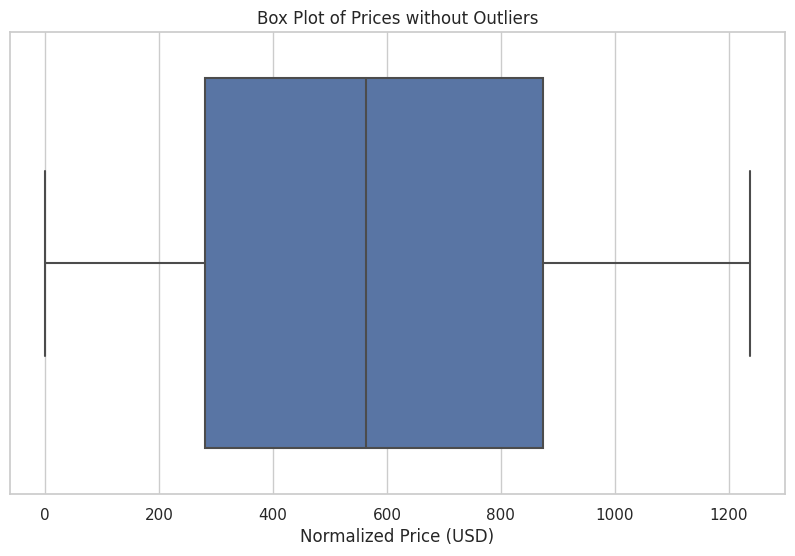

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.boxplot(x='normalized_price_usd', data=price_counts_no_outliers)

plt.title('Box Plot of Prices without Outliers')
plt.xlabel('Normalized Price (USD)')

plt.show()

In [ ]:
focused_no_outliers_df = df_no_outliers[((df_no_outliers['normalized_price_usd'] >= 0) & (df_no_outliers['normalized_price_usd'] < 10)) |
                 ((df_no_outliers['normalized_price_usd'] >= 10) & (df_no_outliers['normalized_price_usd'] < 20)) |
                 ((df_no_outliers['normalized_price_usd'] >= 20) & (df_no_outliers['normalized_price_usd'] < 30)) |
                 ((df_no_outliers['normalized_price_usd'] >= 30) & (df_no_outliers['normalized_price_usd'] < 40)) |
                 ((df_no_outliers['normalized_price_usd'] >= 40) & (df_no_outliers['normalized_price_usd'] < 50)) |
                 ((df_no_outliers['normalized_price_usd'] >= 50) & (df_no_outliers['normalized_price_usd'] < 60)) |
                 ((df_no_outliers['normalized_price_usd'] >= 60) & (df_no_outliers['normalized_price_usd'] < 70)) |
                 ((df_no_outliers['normalized_price_usd'] >= 70) & (df_no_outliers['normalized_price_usd'] < 80)) |
                 ((df_no_outliers['normalized_price_usd'] >= 80) & (df_no_outliers['normalized_price_usd'] < 90)) |
                 ((df_no_outliers['normalized_price_usd'] >= 90) & (df_no_outliers['normalized_price_usd'] < 100)) |
                 ((df_no_outliers['normalized_price_usd'] >= 100) & (df_no_outliers['normalized_price_usd'] <= 200))
                # |
                #  ((df_no_outliers['normalized_price_usd'] >= 200) & (df_no_outliers['normalized_price_usd'] <= 300)) |
                #  ((df_no_outliers['normalized_price_usd'] >= 300) & (df_no_outliers['normalized_price_usd'] < 400)) |
                #  ((df_no_outliers['normalized_price_usd'] >= 400) & (df_no_outliers['normalized_price_usd'] < 500)) |
                #  ((df_no_outliers['normalized_price_usd'] >= 500) & (df_no_outliers['normalized_price_usd'] < 1000)) |
                #  ((df_no_outliers['normalized_price_usd'] >= 1000))
                ]

fig = px.histogram(focused_no_outliers_df, x='normalized_price_usd',
                   nbins=500,
                   title='Price Range Distribution After Removing Outliers')

fig.update_yaxes(range=[0, 2000])

fig.show()

<ipython-input-295-32723fff9432>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



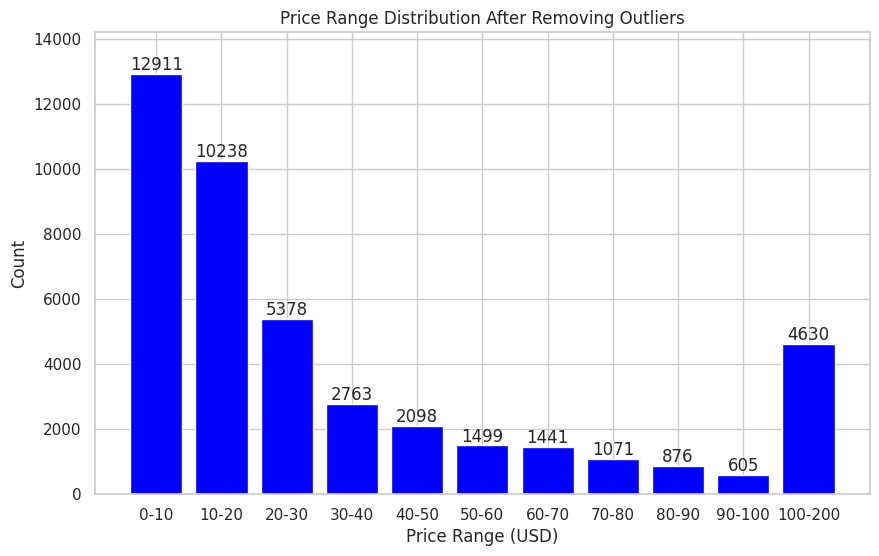

In [ ]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100-200']
df_no_outliers['price_range'] = pd.cut(df_no_outliers['normalized_price_usd'], bins=bins, labels=labels, right=False)

price_range_counts = df_no_outliers['price_range'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(price_range_counts.index.astype(str), price_range_counts.values, color='blue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xlabel('Price Range (USD)')
plt.ylabel('Count')
plt.title('Price Range Distribution After Removing Outliers')

plt.ylim(0, price_range_counts.max() * 1.1)

plt.show()

In [ ]:
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 200, 300, 400]
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

focused_no_outliers_df['price_range'] = pd.cut(focused_no_outliers_df['normalized_price_usd'], bins=bins, labels=labels, right=False)

pie_data = focused_no_outliers_df['price_range'].value_counts().reset_index()
pie_data.columns = ['price_range', 'count']

fig = px.pie(pie_data, values='count', names='price_range', title='Pie Chart of Price Range from USD 0 to USD 200')

fig.show()

# Export the pre-processed final data (w/o outliers) into csv file

In [ ]:
# FINAL FILE (removed price outliers)
output_file_path = '/content/drive/MyDrive/Big Data/Team Notebook/data/preprocessed_data_file_geography_price_removed_outliers.csv'
df_no_outliers.to_csv(output_file_path, index=False)